## 0. Подготовка окружения

In [1]:
# ============================================================
# ЭТАП 0.1 — подключение Google Drive, пути, воспроизводимость
# ============================================================

import os
import random
import json
import numpy as np

# Если вы будете использовать torch / tf позже — сразу заложим задел
try:
    import torch
except ImportError:
    torch = None

try:
    import tensorflow as tf
except ImportError:
    tf = None

# --- Подключение Google Drive (работает только в Colab) ---
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/MyDrive/digital_marketing_conversion"
else:
    # Локальный fallback — можно поменять под себя
    BASE_DIR = os.path.abspath("./digital_marketing_conversion")

DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")

for d in [BASE_DIR, DATA_DIR, MODELS_DIR, PLOTS_DIR, REPORTS_DIR, ARTIFACTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("PLOTS_DIR:", PLOTS_DIR)
print("REPORTS_DIR:", REPORTS_DIR)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)

# --- Функция для установки случайных зерен ---
def set_global_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)

    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        # Дополнительно чуть жёстче фиксируем детерминизм
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    if tf is not None:
        try:
            tf.random.set_seed(seed)
        except Exception:
            pass

    print(f"[INFO] Глобальное зерно случайности установлено: {seed}")

set_global_seed(42)

# --- Проверка наличия GPU ---
if torch is not None and torch.cuda.is_available():
    print("[INFO] PyTorch видит GPU:", torch.cuda.get_device_name(0))
elif tf is not None and len(tf.config.list_physical_devices("GPU")) > 0:
    print("[INFO] TensorFlow видит GPU:", tf.config.list_physical_devices("GPU"))
else:
    print("[WARN] GPU не обнаружен (или библиотеки DL ещё не установлены).")
    print("       Но для датасета на 8000 строк это не критично.")

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/digital_marketing_conversion
DATA_DIR: /content/drive/MyDrive/digital_marketing_conversion/data
MODELS_DIR: /content/drive/MyDrive/digital_marketing_conversion/models
PLOTS_DIR: /content/drive/MyDrive/digital_marketing_conversion/plots
REPORTS_DIR: /content/drive/MyDrive/digital_marketing_conversion/reports
ARTIFACTS_DIR: /content/drive/MyDrive/digital_marketing_conversion/artifacts
[INFO] Глобальное зерно случайности установлено: 42
[INFO] PyTorch видит GPU: Tesla T4


In [2]:
# ============================================================
# ЭТАП 0.2 — установка необходимых библиотек
# ============================================================

# Базовые библиотеки анализа данных и визуализации
!pip install -q pandas numpy matplotlib seaborn

# ML-стек (дальше пригодится, но уже сейчас можно поставить)
!pip install -q scikit-learn imbalanced-learn xgboost lightgbm shap umap-learn

# Работа с Kaggle API и конфигами
!pip install -q kaggle pyyaml

In [3]:
# ============================================================
# ЭТАП 0.3 — загрузка kaggle.json и скачивание датасета Kaggle
# ============================================================

import os
import zipfile
from pathlib import Path

if IN_COLAB:
    from google.colab import files  # type: ignore

    print(
        "Пожалуйста, загрузите kaggle.json (из профиля Kaggle → Account → Create New Token)."
    )
    uploaded = files.upload()  # Откроется диалог выбора файла

    if "kaggle.json" not in uploaded:
        raise FileNotFoundError(
            "Файл kaggle.json не найден среди загруженных. "
            "Убедитесь, что выбрали правильный файл."
        )

    # Настройка Kaggle API
    kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
    os.makedirs(kaggle_dir, exist_ok=True)

    with open("kaggle.json", "r") as f_in:
        token = json.load(f_in)

    kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
    with open(kaggle_json_path, "w") as f_out:
        json.dump(token, f_out)

    os.chmod(kaggle_json_path, 0o600)
    print("[INFO] kaggle.json настроен.")

    # Скачивание датасета
    print("[INFO] Скачиваю датасет 'Predict Conversion in Digital Marketing'...")
    !kaggle datasets download -d rabieelkharoua/predict-conversion-in-digital-marketing-dataset -p {DATA_DIR} --unzip

    # Проверим, какие CSV появились
    csv_files = list(Path(DATA_DIR).glob("*.csv"))
    print("[INFO] Найдены CSV-файлы в DATA_DIR:")
    for p in csv_files:
        print("   -", p.name)

else:
    print(
        "[WARN] Не в Colab: этот блок рассчитан на Google Colab и может не работать локально."
    )

Пожалуйста, загрузите kaggle.json (из профиля Kaggle → Account → Create New Token).


Saving kaggle.json to kaggle.json
[INFO] kaggle.json настроен.
[INFO] Скачиваю датасет 'Predict Conversion in Digital Marketing'...
Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/predict-conversion-in-digital-marketing-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/529k [00:00<?, ?B/s]
100% 529k/529k [00:00<00:00, 62.8MB/s]
[INFO] Найдены CSV-файлы в DATA_DIR:
   - digital_marketing_campaign_dataset.csv


In [4]:
# ============================================================
# ЭТАП 0.4 — (опционально) регистрация путей к нескольким датасетам
# ============================================================

import yaml

dataset_registry_path = os.path.join(DATA_DIR, "dataset_registry.yaml")

# Попробуем автоматически найти основной CSV
from glob import glob

csv_files = glob(os.path.join(DATA_DIR, "*.csv"))

main_dataset_path = None
for candidate in csv_files:
    name = os.path.basename(candidate).lower()
    if "digital_marketing_campaign" in name:
        main_dataset_path = candidate
        break

if main_dataset_path is None and csv_files:
    main_dataset_path = csv_files[0]  # fallback — первый найденный CSV

dataset_registry = {
    "main_conversion_dataset": {
        "source": "kaggle",
        "kaggle_dataset": "rabieelkharoua/predict-conversion-in-digital-marketing-dataset",
        "path": main_dataset_path,
        "description": "Predict Conversion in Digital Marketing Dataset (основной датасет для экспериментов)",
    },
    # Сюда позже можно дописать ещё один датасет (stuffmart, др.)
}

with open(dataset_registry_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(dataset_registry, f, allow_unicode=True)

print("[INFO] dataset_registry.yaml сохранён по пути:", dataset_registry_path)
print("       Основной датасет:", main_dataset_path)

[INFO] dataset_registry.yaml сохранён по пути: /content/drive/MyDrive/digital_marketing_conversion/data/dataset_registry.yaml
       Основной датасет: /content/drive/MyDrive/digital_marketing_conversion/data/digital_marketing_campaign_dataset.csv


## Этап 1. Первичный анализ данных

In [14]:
# ============================================================
# ЭТАП 1.1 — чтение датасета и общий профиль
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

# Грузим registry, чтобы взять путь к датасету
with open(dataset_registry_path, "r", encoding="utf-8") as f:
    dataset_registry = yaml.safe_load(f)

main_dataset_info = dataset_registry["main_conversion_dataset"]
csv_path = main_dataset_info["path"]

if csv_path is None or not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV-файл основного датасета не найден. Ожидался путь: {csv_path}"
    )

print("[INFO] Загружаю основной датасет из:", csv_path)
df = pd.read_csv(csv_path)

print("\n[SHAPE] Размерность датасета:", df.shape)
print("\n[D_TYPES] Типы данных колонок:")
print(df.dtypes)

print("\n[HEAD] Первые 5 строк:")
display(df.head())

print("\n[NA] Количество пропусков в каждом столбце:")
print(df.isna().sum())

print("\n[DESCRIBE] Базовая статистика по числовым признакам:")
display(df.describe().T)

# --- Data Dictionary / Feature Catalog ---
feature_catalog = pd.DataFrame(
    {
        "feature_name": df.columns,
        "dtype": [str(dt) for dt in df.dtypes],
        "n_unique": [df[col].nunique() for col in df.columns],
        "n_missing": [df[col].isna().sum() for col in df.columns],
        # поле для ручного заполнения в отчёте при необходимости
        "description_ru": ["" for _ in df.columns],
        "example_value": [df[col].iloc[0] for col in df.columns],
    }
)

feature_catalog_path = os.path.join(DATA_DIR, "feature_catalog.csv")
feature_catalog.to_csv(feature_catalog_path, index=False, encoding="utf-8-sig")
print("\n[INFO] Каталог признаков сохранён в:", feature_catalog_path)
display(feature_catalog)

[INFO] Загружаю основной датасет из: /content/drive/MyDrive/digital_marketing_conversion/data/digital_marketing_campaign_dataset.csv

[SHAPE] Размерность датасета: (8000, 20)

[D_TYPES] Типы данных колонок:
CustomerID               int64
Age                      int64
Gender                  object
Income                   int64
CampaignChannel         object
CampaignType            object
AdSpend                float64
ClickThroughRate       float64
ConversionRate         float64
WebsiteVisits            int64
PagesPerVisit          float64
TimeOnSite             float64
SocialShares             int64
EmailOpens               int64
EmailClicks              int64
PreviousPurchases        int64
LoyaltyPoints            int64
AdvertisingPlatform     object
AdvertisingTool         object
Conversion               int64
dtype: object

[HEAD] Первые 5 строк:


CustomerID  Age  Gender  Income CampaignChannel CampaignType      AdSpend  \
0        8000   56  Female  136912    Social Media    Awareness  6497.870068   
1        8001   69    Male   41760           Email    Retention  3898.668606   
2        8002   46  Female   88456             PPC    Awareness  1546.429596   
3        8003   32  Female   44085             PPC   Conversion   539.525936   
4        8004   60  Female   83964             PPC   Conversion  1678.043573   

   ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  TimeOnSite  \
0          0.043919        0.088031              0       2.399017    7.396803   
1          0.155725        0.182725             42       2.917138    5.352549   
2          0.277490        0.076423              2       8.223619   13.794901   
3          0.137611        0.088004             47       4.540939   14.688363   
4          0.252851        0.109940              0       2.046847   13.993370   

   SocialShares  EmailOpens  EmailClicks  PreviousPurchases  LoyaltyPoints  \
0            19           6            9                  4            688   
1             5           2            7                  2           3459   
2             0          11            2                  8           2337   
3            89           2            2                  0           2463   
4             6           6            6                  8           4345   

  AdvertisingPlatform AdvertisingTool  Conversion  
0            IsConfid      ToolConfid           1  
1            IsConfid      ToolConfid           1  
2            IsConfid      ToolConfid           1  
3            IsConfid      ToolConfid           1  
4            IsConfid      ToolConfid           1


[NA] Количество пропусков в каждом столбце:
CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

[DESCRIBE] Базовая статистика по числовым признакам:


count          mean           std           min  \
CustomerID         8000.0  11999.500000   2309.545410   8000.000000   
Age                8000.0     43.625500     14.902785     18.000000   
Income             8000.0  84664.196750  37580.387945  20014.000000   
AdSpend            8000.0   5000.944830   2838.038153    100.054813   
ClickThroughRate   8000.0      0.154829      0.084007      0.010005   
ConversionRate     8000.0      0.104389      0.054878      0.010018   
WebsiteVisits      8000.0     24.751625     14.312269      0.000000   
PagesPerVisit      8000.0      5.549299      2.607358      1.000428   
TimeOnSite         8000.0      7.727718      4.228218      0.501669   
SocialShares       8000.0     49.799750     28.901165      0.000000   
EmailOpens         8000.0      9.476875      5.711111      0.000000   
EmailClicks        8000.0      4.467375      2.856564      0.000000   
PreviousPurchases  8000.0      4.485500      2.888093      0.000000   
LoyaltyPoints      8000.0   2490.268500   1429.527162      0.000000   
Conversion         8000.0      0.876500      0.329031      0.000000   

                            25%           50%            75%            max  
CustomerID          9999.750000  11999.500000   13999.250000   15999.000000  
Age                   31.000000     43.000000      56.000000      69.000000  
Income             51744.500000  84926.500000  116815.750000  149986.000000  
AdSpend             2523.221165   5013.440044    7407.989369    9997.914781  
ClickThroughRate       0.082635      0.154505       0.228207       0.299968  
ConversionRate         0.056410      0.104046       0.152077       0.199995  
WebsiteVisits         13.000000     25.000000      37.000000      49.000000  
PagesPerVisit          3.302479      5.534257       7.835756       9.999055  
TimeOnSite             4.068340      7.682956      11.481468      14.995311  
SocialShares          25.000000     50.000000      75.000000      99.000000  
EmailOpens             5.000000      9.000000      14.000000      19.000000  
EmailClicks            2.000000      4.000000       7.000000       9.000000  
PreviousPurchases      2.000000      4.000000       7.000000       9.000000  
LoyaltyPoints       1254.750000   2497.000000    3702.250000    4999.000000  
Conversion             1.000000      1.000000       1.000000       1.000000


[INFO] Каталог признаков сохранён в: /content/drive/MyDrive/digital_marketing_conversion/data/feature_catalog.csv


feature_name    dtype  n_unique  n_missing description_ru  \
0            CustomerID    int64      8000          0                  
1                   Age    int64        52          0                  
2                Gender   object         2          0                  
3                Income    int64      7789          0                  
4       CampaignChannel   object         5          0                  
5          CampaignType   object         4          0                  
6               AdSpend  float64      8000          0                  
7      ClickThroughRate  float64      8000          0                  
8        ConversionRate  float64      8000          0                  
9         WebsiteVisits    int64        50          0                  
10        PagesPerVisit  float64      8000          0                  
11           TimeOnSite  float64      8000          0                  
12         SocialShares    int64       100          0                  
13           EmailOpens    int64        20          0                  
14          EmailClicks    int64        10          0                  
15    PreviousPurchases    int64        10          0                  
16        LoyaltyPoints    int64      3983          0                  
17  AdvertisingPlatform   object         1          0                  
18      AdvertisingTool   object         1          0                  
19           Conversion    int64         2          0                  

   example_value  
0           8000  
1             56  
2         Female  
3         136912  
4   Social Media  
5      Awareness  
6    6497.870068  
7       0.043919  
8       0.088031  
9              0  
10      2.399017  
11      7.396803  
12            19  
13             6  
14             9  
15             4  
16           688  
17      IsConfid  
18    ToolConfid  
19             1


[INFO] Распределение целевой переменной (сырые значения):
Conversion
0     988
1    7012
Name: count, dtype: int64

[INFO] Распределение целевой переменной (доли):
Conversion
0    0.1235
1    0.8765
Name: proportion, dtype: float64


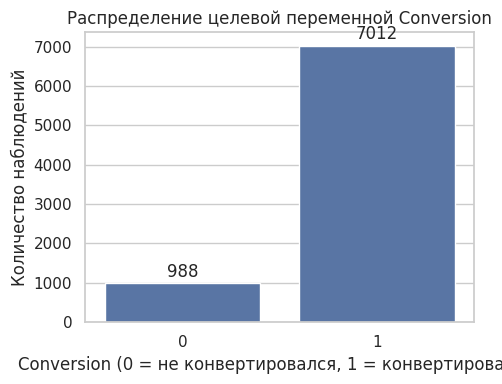

[INFO] График распределения таргета сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/target_distribution_conversion.png


In [15]:
# ============================================================
# ЭТАП 1.2 — анализ целевой переменной Conversion
# ============================================================
TARGET_COL = "Conversion"

if TARGET_COL not in df.columns:
    raise KeyError(
        f"Ожидалась колонка таргета '{TARGET_COL}', но её нет в df.columns: {df.columns.tolist()}"
    )

target_counts = df[TARGET_COL].value_counts().sort_index()
target_probs = df[TARGET_COL].value_counts(normalize=True).sort_index()

print("\n[INFO] Распределение целевой переменной (сырые значения):")
print(target_counts)
print("\n[INFO] Распределение целевой переменной (доли):")
print(target_probs)

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(
    x=target_counts.index.astype(str),
    y=target_counts.values,
    ax=ax,
)
ax.set_xlabel("Conversion (0 = не конвертировался, 1 = конвертировался)")
ax.set_ylabel("Количество наблюдений")
ax.set_title("Распределение целевой переменной Conversion")
for i, v in enumerate(target_counts.values):
    ax.text(i, v + 0.01 * max(target_counts.values), str(v), ha="center", va="bottom")
plt.tight_layout()

target_plot_path = os.path.join(PLOTS_DIR, "target_distribution_conversion.png")
plt.savefig(target_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График распределения таргета сохранён в:", target_plot_path)


[INFO] Числовые признаки (без таргета и ID): ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']
[INFO] Категориальные признаки: ['Gender', 'CampaignChannel', 'CampaignType', 'AdvertisingPlatform', 'AdvertisingTool']


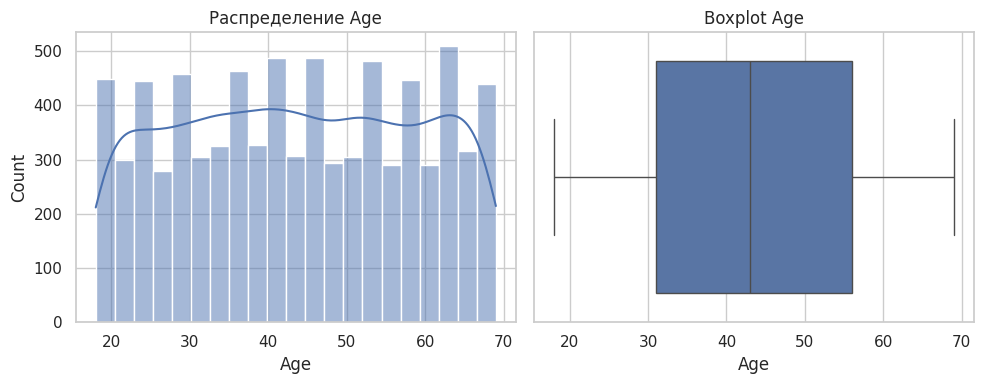

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_Age.png


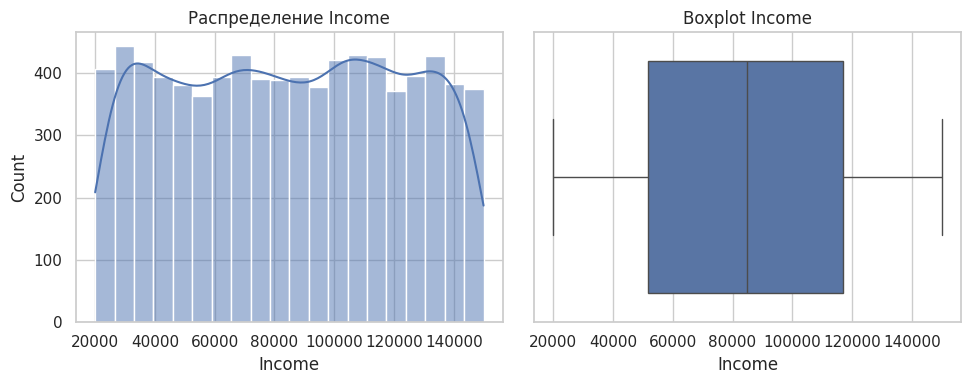

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_Income.png


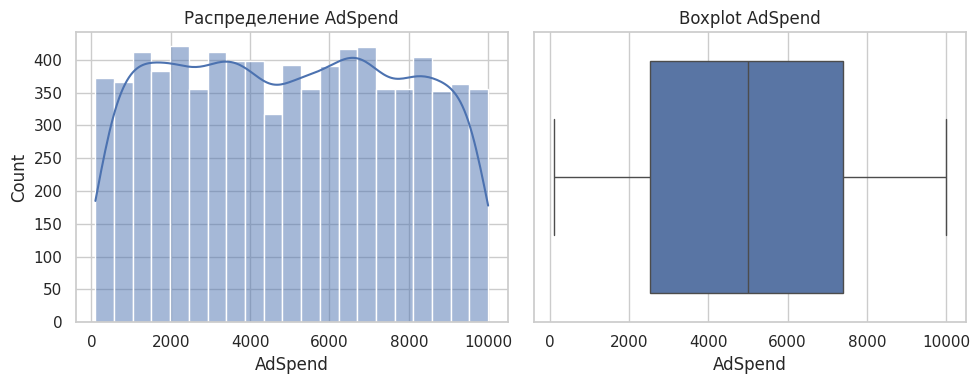

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_AdSpend.png


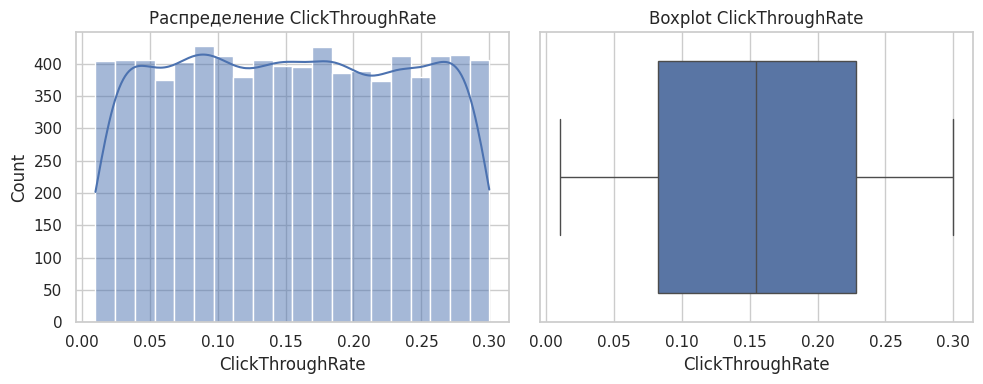

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_ClickThroughRate.png


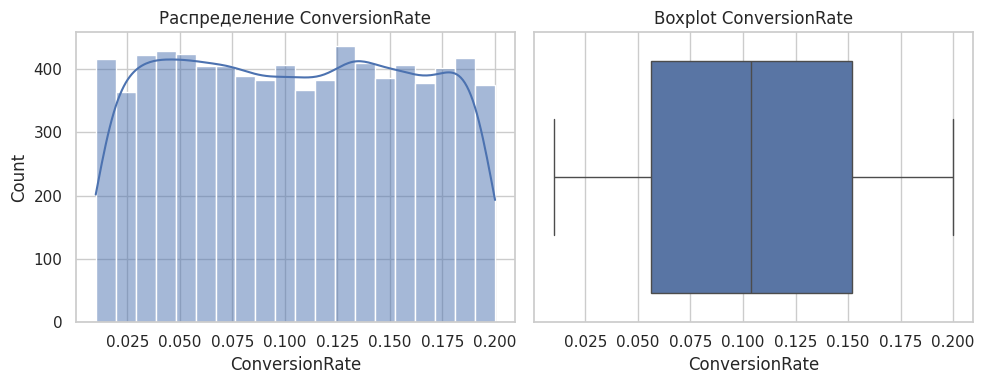

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_ConversionRate.png


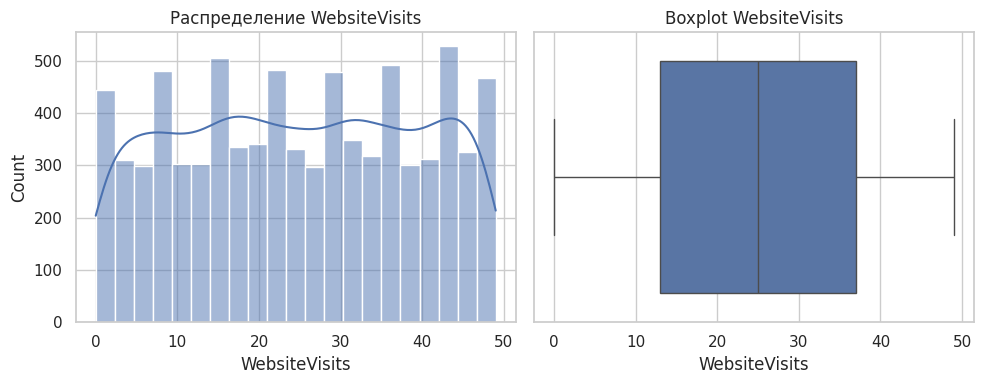

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_WebsiteVisits.png


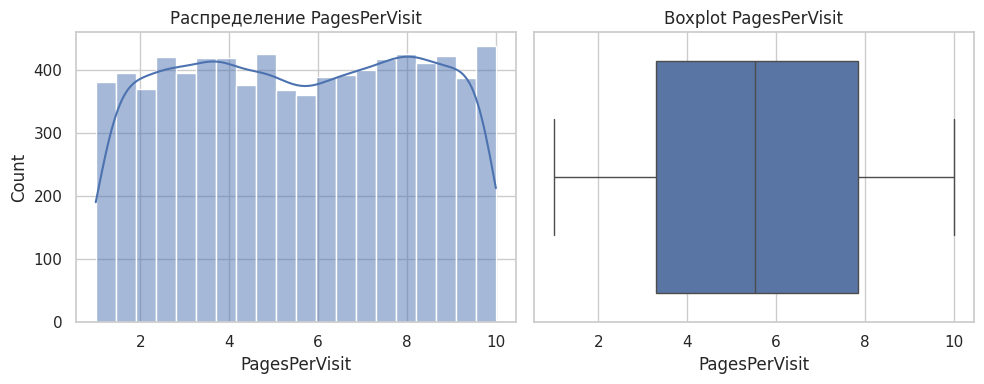

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_PagesPerVisit.png


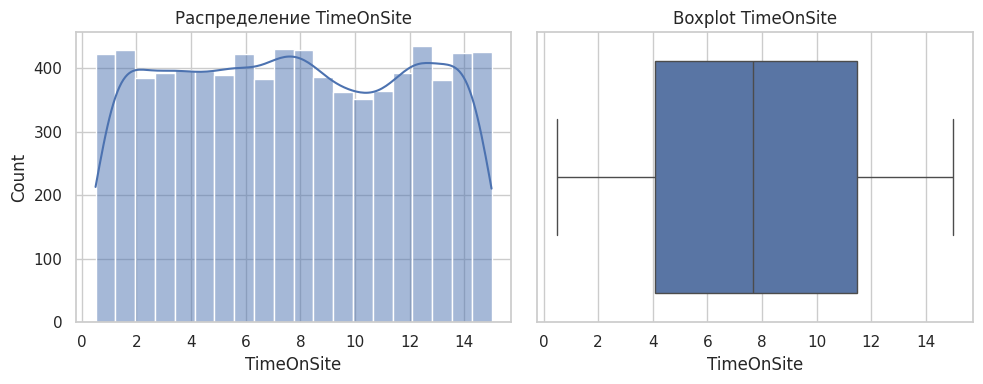

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_TimeOnSite.png


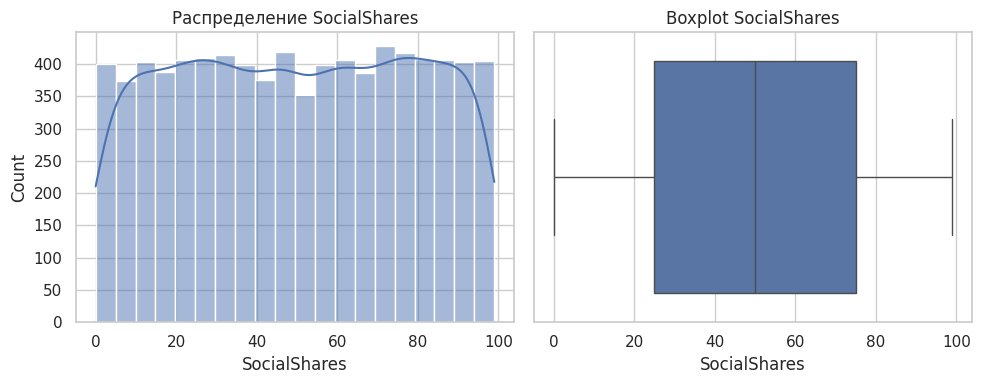

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_SocialShares.png


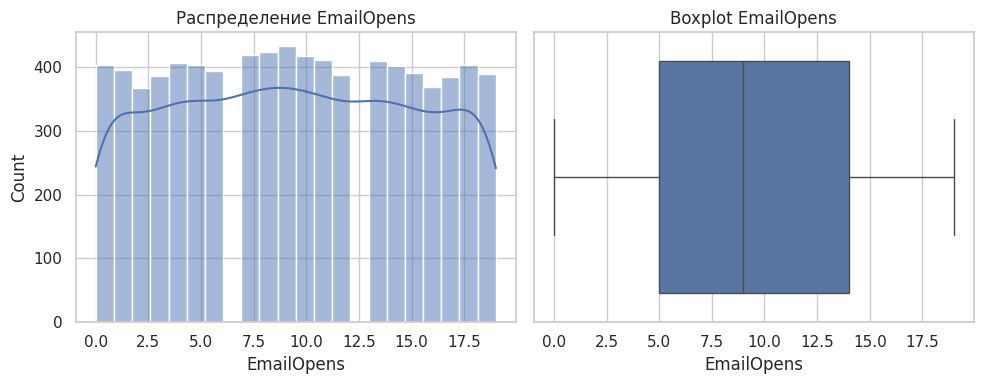

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_EmailOpens.png


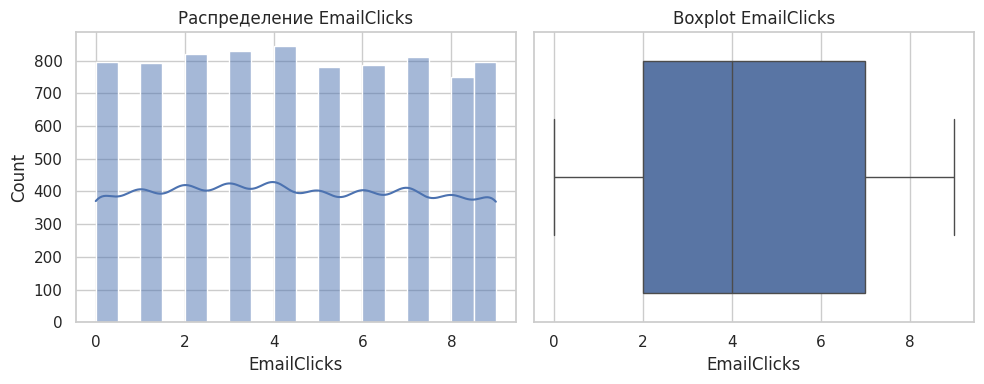

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_EmailClicks.png


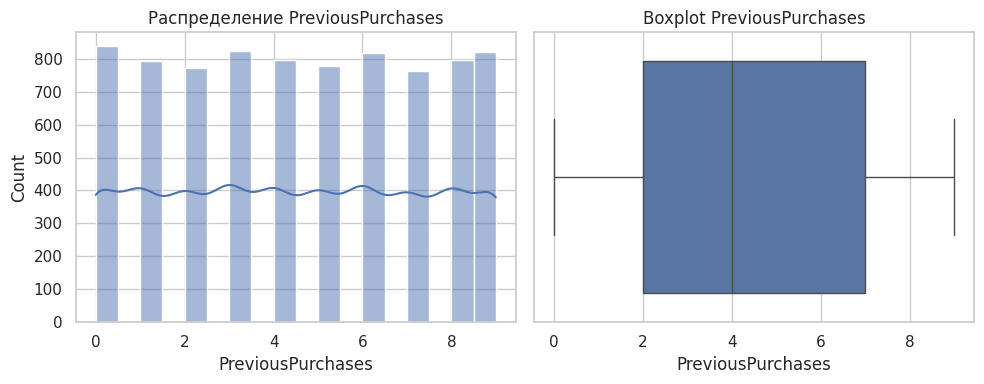

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_PreviousPurchases.png


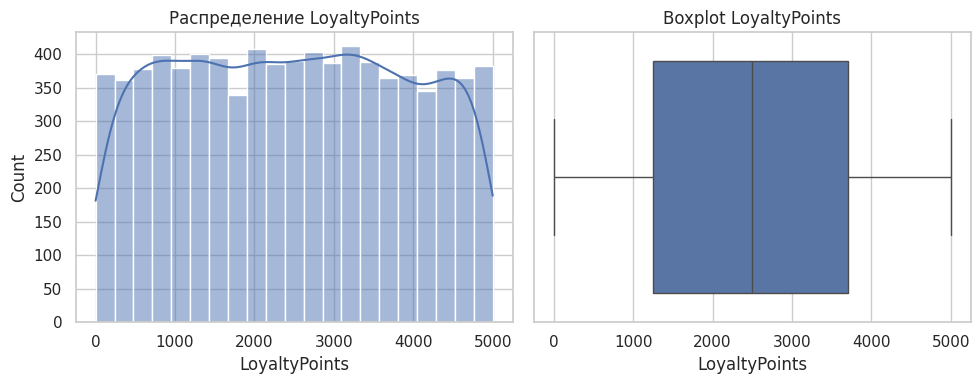

[INFO] Сохранена визуализация числового признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_numeric_LoyaltyPoints.png


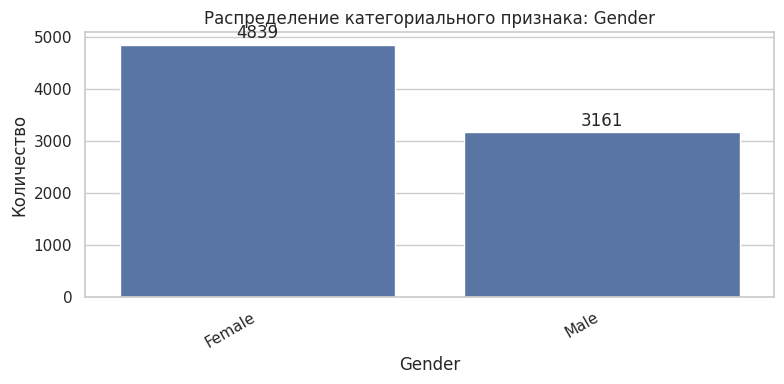

[INFO] Сохранена визуализация категориального признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_categorical_Gender.png


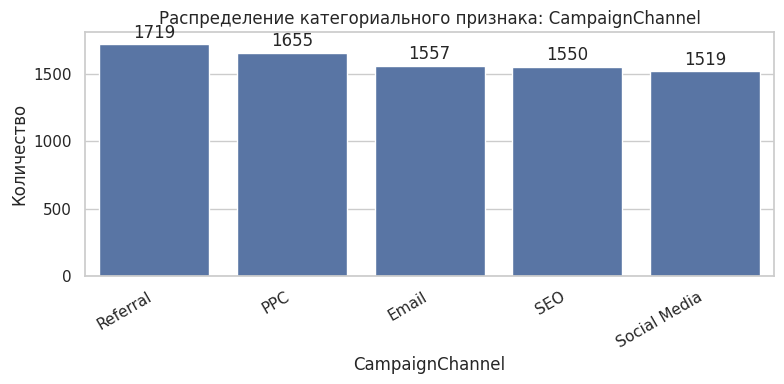

[INFO] Сохранена визуализация категориального признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_categorical_CampaignChannel.png


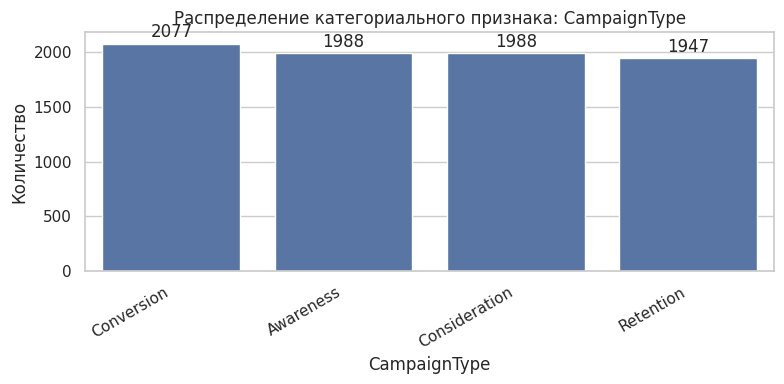

[INFO] Сохранена визуализация категориального признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_categorical_CampaignType.png


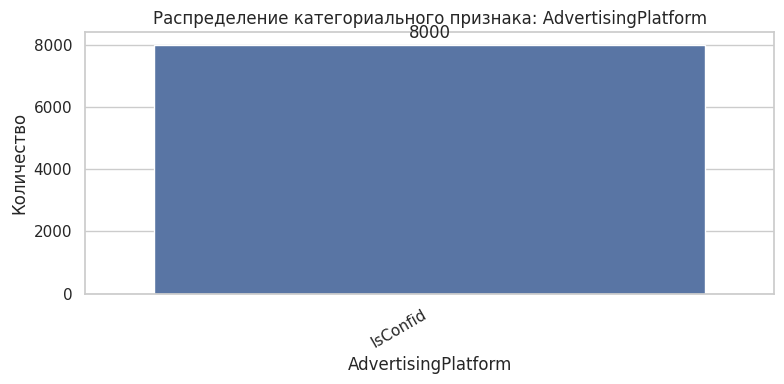

[INFO] Сохранена визуализация категориального признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_categorical_AdvertisingPlatform.png


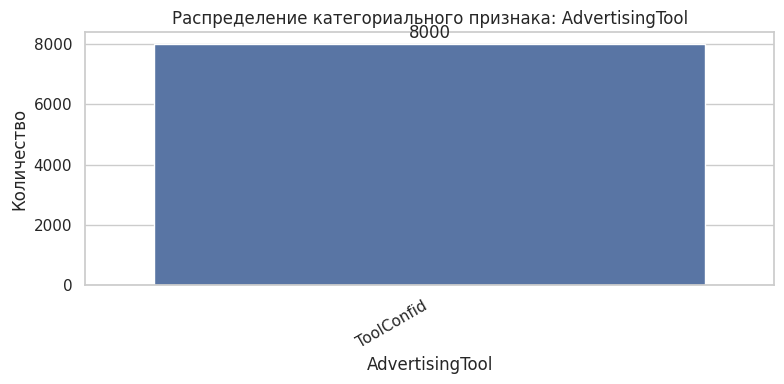

[INFO] Сохранена визуализация категориального признака: /content/drive/MyDrive/digital_marketing_conversion/plots/univariate_categorical_AdvertisingTool.png


In [16]:
# ============================================================
# ЭТАП 1.3 — однофакторные визуализации (числовые + категориальные)
# ============================================================

# Будем считать, что ID-поле нам не надо в анализе распределений
ID_CANDIDATES = ["CustomerID", "customer_id", "ID", "id"]
id_cols = [c for c in df.columns if c in ID_CANDIDATES]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# исключаем цель и ID из числовых
numeric_cols = [c for c in numeric_cols if c not in [TARGET_COL] + id_cols]

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("\n[INFO] Числовые признаки (без таргета и ID):", numeric_cols)
print("[INFO] Категориальные признаки:", categorical_cols)

# --- Гистограммы и boxplot для числовых признаков ---
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Гистограмма
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Распределение {col}")
    axes[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    hist_path = os.path.join(PLOTS_DIR, f"univariate_numeric_{col}.png")
    plt.savefig(hist_path, dpi=150)
    plt.show()
    plt.close()

    print(f"[INFO] Сохранена визуализация числового признака: {hist_path}")

# --- Бар-чарты для категориальных признаков ---
for col in categorical_cols:
    vc = df[col].value_counts().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=vc.index, y=vc.values, ax=ax)
    ax.set_title(f"Распределение категориального признака: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Количество")

    # подписи значений
    for i, v in enumerate(vc.values):
        ax.text(i, v + 0.01 * max(vc.values), str(v), ha="center", va="bottom", rotation=0)

    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    cat_path = os.path.join(PLOTS_DIR, f"univariate_categorical_{col}.png")
    plt.savefig(cat_path, dpi=150)
    plt.show()
    plt.close()

    print(f"[INFO] Сохранена визуализация категориального признака: {cat_path}")


[SUMMARY] Конверсия по признаку Gender:


conversion_rate     n
Gender                       
Male           0.876938  3161
Female         0.876214  4839

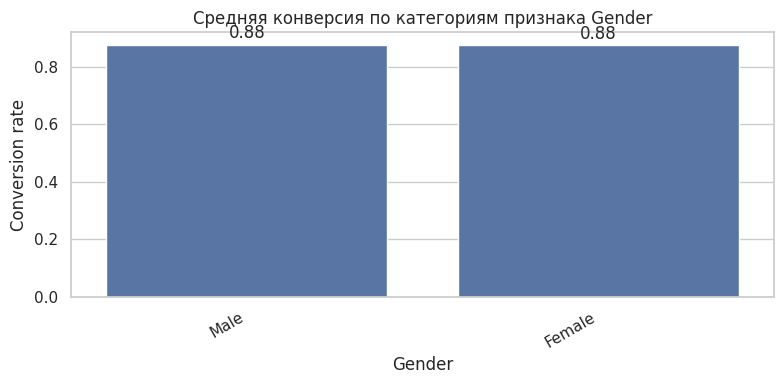

[INFO] Сохранён график конверсии по признаку Gender: /content/drive/MyDrive/digital_marketing_conversion/plots/conversion_by_Gender.png

[SUMMARY] Конверсия по признаку CampaignChannel:


conversion_rate     n
CampaignChannel                       
Referral                0.883072  1719
PPC                     0.882779  1655
SEO                     0.876774  1550
Email                   0.870263  1557
Social Media            0.868334  1519

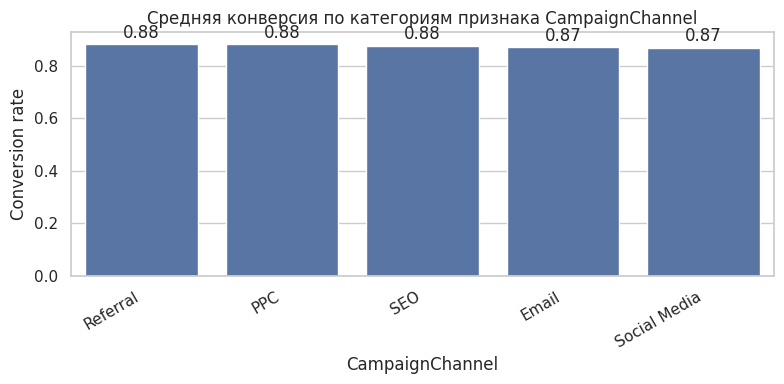

[INFO] Сохранён график конверсии по признаку CampaignChannel: /content/drive/MyDrive/digital_marketing_conversion/plots/conversion_by_CampaignChannel.png

[SUMMARY] Конверсия по признаку CampaignType:


conversion_rate     n
CampaignType                        
Conversion            0.933558  2077
Retention             0.858243  1947
Consideration         0.855634  1988
Awareness             0.855634  1988

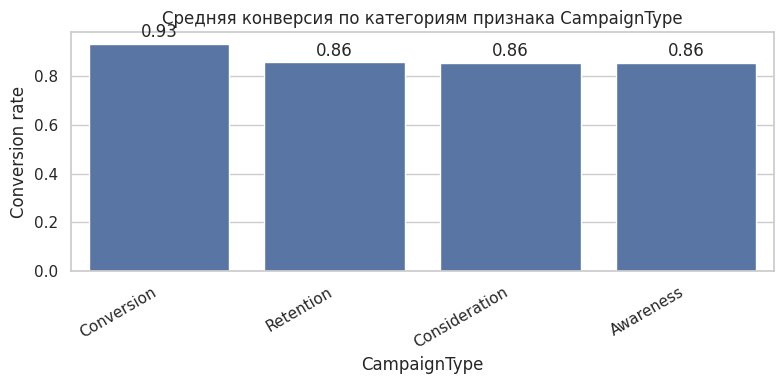

[INFO] Сохранён график конверсии по признаку CampaignType: /content/drive/MyDrive/digital_marketing_conversion/plots/conversion_by_CampaignType.png

[SUMMARY] Конверсия по признаку AdvertisingPlatform:


conversion_rate     n
AdvertisingPlatform                       
IsConfid                      0.8765  8000

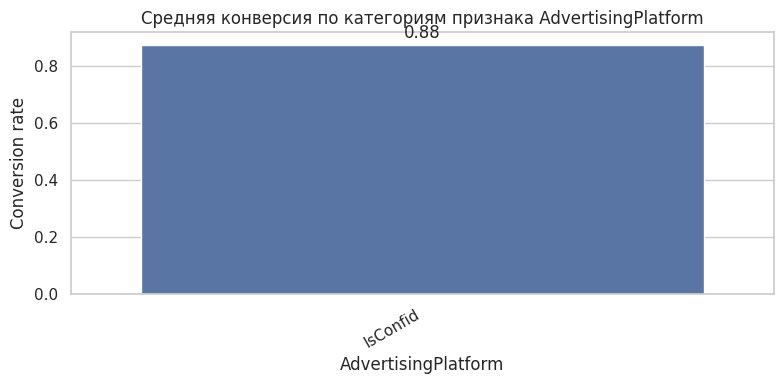

[INFO] Сохранён график конверсии по признаку AdvertisingPlatform: /content/drive/MyDrive/digital_marketing_conversion/plots/conversion_by_AdvertisingPlatform.png

[SUMMARY] Конверсия по признаку AdvertisingTool:


conversion_rate     n
AdvertisingTool                       
ToolConfid                0.8765  8000

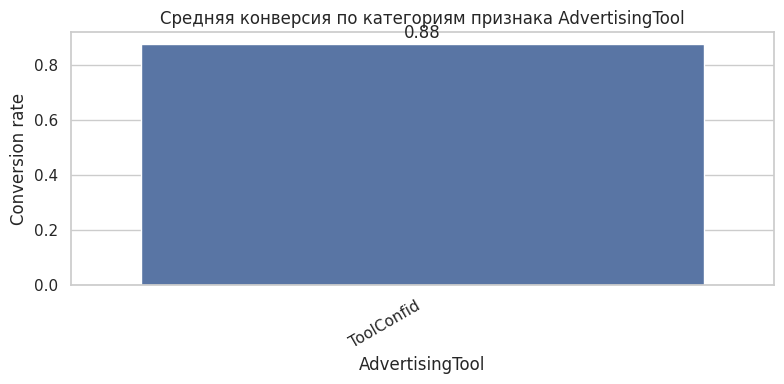

[INFO] Сохранён график конверсии по признаку AdvertisingTool: /content/drive/MyDrive/digital_marketing_conversion/plots/conversion_by_AdvertisingTool.png

[INFO] Таблица с конверсией по категориальным признакам сохранена в: /content/drive/MyDrive/digital_marketing_conversion/data/conversion_summary_by_categorical.csv


feature  Gender  conversion_rate     n CampaignChannel  \
0           Gender    Male         0.876938  3161             NaN   
1           Gender  Female         0.876214  4839             NaN   
2  CampaignChannel     NaN         0.883072  1719        Referral   
3  CampaignChannel     NaN         0.882779  1655             PPC   
4  CampaignChannel     NaN         0.876774  1550             SEO   

  CampaignType AdvertisingPlatform AdvertisingTool  
0          NaN                 NaN             NaN  
1          NaN                 NaN             NaN  
2          NaN                 NaN             NaN  
3          NaN                 NaN             NaN  
4          NaN                 NaN             NaN

In [17]:
# ============================================================
# ЭТАП 1.4 — конверсия по ключевым категориальным признакам
# ============================================================

conversion_summary_rows = []

for col in categorical_cols:
    # Считаем среднюю конверсию по категориям
    group_df = (
        df.groupby(col)[TARGET_COL]
        .agg(["mean", "count"])
        .rename(columns={"mean": "conversion_rate", "count": "n"})
        .sort_values("conversion_rate", ascending=False)
    )

    print(f"\n[SUMMARY] Конверсия по признаку {col}:")
    display(group_df)

    # Сохраним в список для дальнейшего объединения
    tmp = group_df.reset_index()
    tmp.insert(0, "feature", col)
    conversion_summary_rows.append(tmp)

    # Визуализация
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(
        data=group_df.reset_index(),
        x=col,
        y="conversion_rate",
        ax=ax,
    )
    ax.set_title(f"Средняя конверсия по категориям признака {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Conversion rate")

    for i, (category, row) in enumerate(group_df.reset_index()[[col, "conversion_rate"]].values):
        ax.text(i, row + 0.01 * group_df["conversion_rate"].max(), f"{row:.2f}", ha="center", va="bottom")

    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    conv_plot_path = os.path.join(PLOTS_DIR, f"conversion_by_{col}.png")
    plt.savefig(conv_plot_path, dpi=150)
    plt.show()
    plt.close()

    print(f"[INFO] Сохранён график конверсии по признаку {col}: {conv_plot_path}")

# Объединяем все summary в один DataFrame и сохраняем
if conversion_summary_rows:
    conv_summary_df = pd.concat(conversion_summary_rows, ignore_index=True)
    conv_summary_path = os.path.join(DATA_DIR, "conversion_summary_by_categorical.csv")
    conv_summary_df.to_csv(conv_summary_path, index=False, encoding="utf-8-sig")
    print(
        "\n[INFO] Таблица с конверсией по категориальным признакам сохранена в:",
        conv_summary_path,
    )
    display(conv_summary_df.head())
else:
    print("[WARN] Нет категориальных признаков для расчёта конверсии.")


[INFO] Числовые признаки для корреляции: ['CustomerID', 'Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'Conversion']


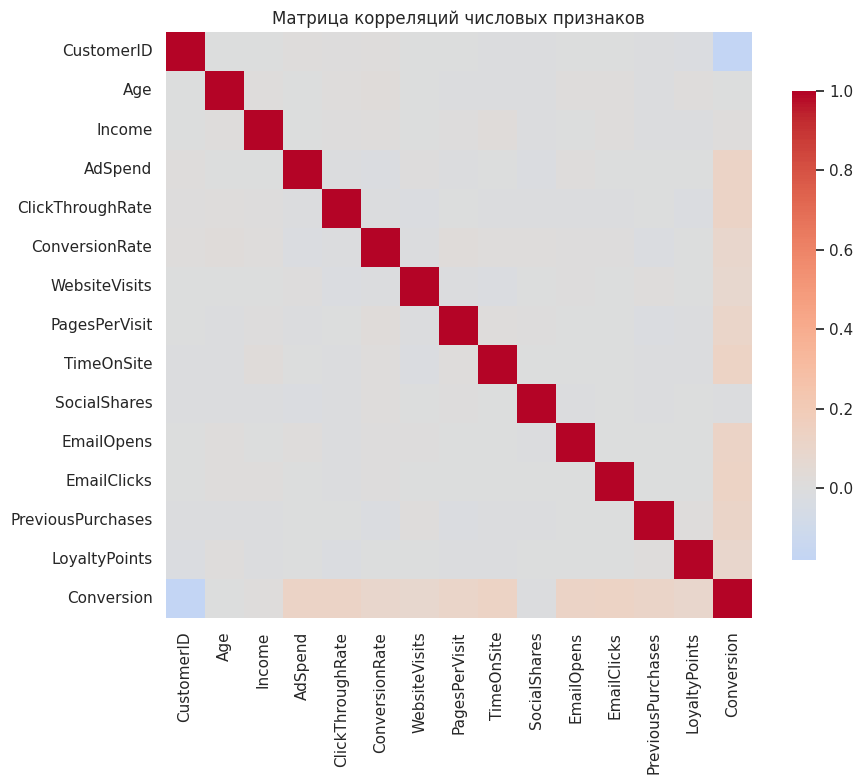

[INFO] Матрица корреляций сохранена в: /content/drive/MyDrive/digital_marketing_conversion/plots/correlation_matrix_numeric.png


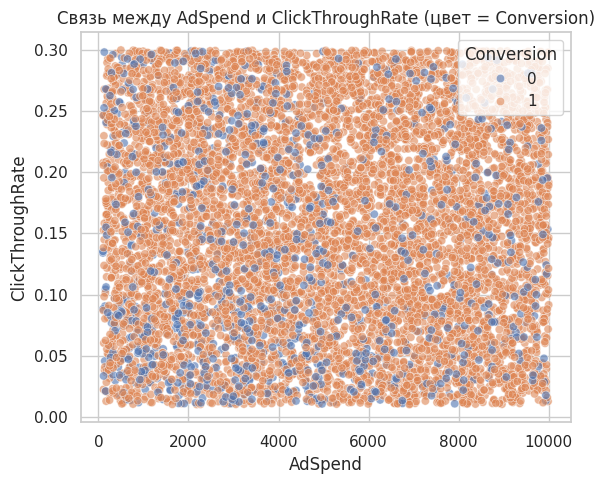

[INFO] Сохранён график связи AdSpend vs ClickThroughRate: /content/drive/MyDrive/digital_marketing_conversion/plots/pair_AdSpend_vs_ClickThroughRate.png


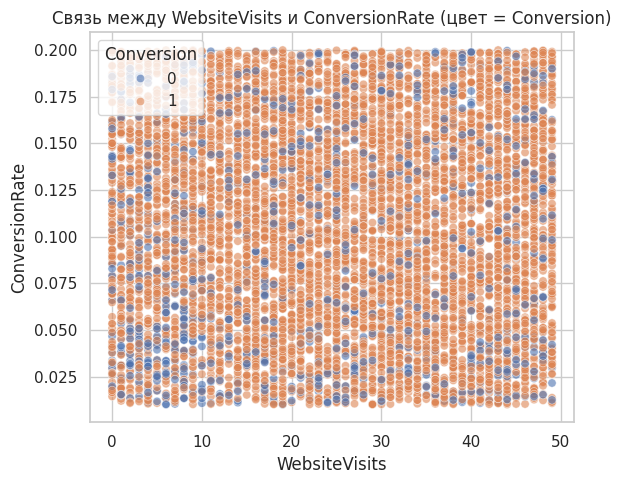

[INFO] Сохранён график связи WebsiteVisits vs ConversionRate: /content/drive/MyDrive/digital_marketing_conversion/plots/pair_WebsiteVisits_vs_ConversionRate.png


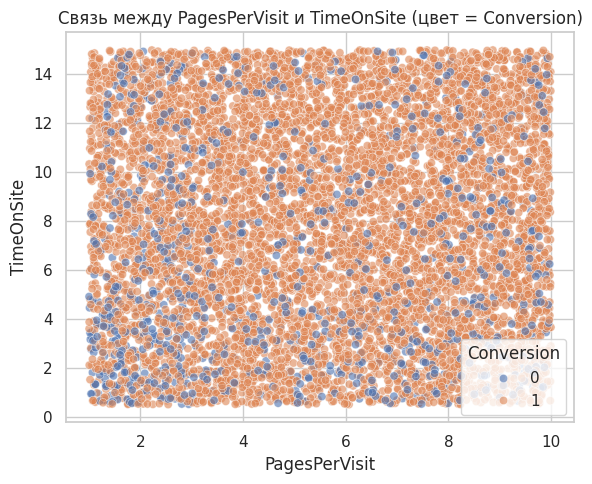

[INFO] Сохранён график связи PagesPerVisit vs TimeOnSite: /content/drive/MyDrive/digital_marketing_conversion/plots/pair_PagesPerVisit_vs_TimeOnSite.png


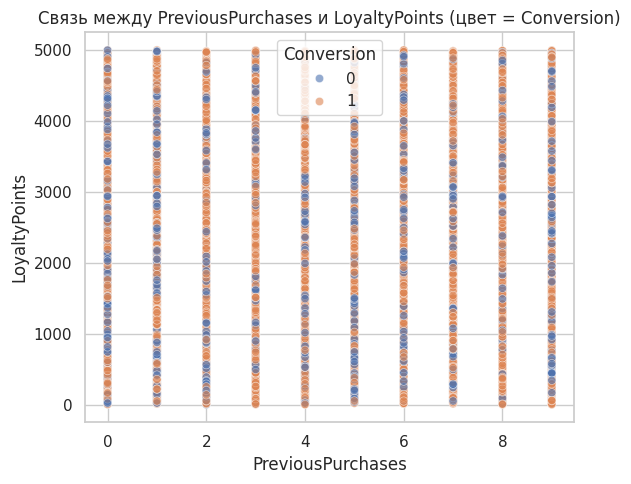

[INFO] Сохранён график связи PreviousPurchases vs LoyaltyPoints: /content/drive/MyDrive/digital_marketing_conversion/plots/pair_PreviousPurchases_vs_LoyaltyPoints.png


In [18]:
# ============================================================
# ЭТАП 1.5 — матрица корреляций и парные связи числовых признаков
# ============================================================

corr_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\n[INFO] Числовые признаки для корреляции:", corr_cols)

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0.0,
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Матрица корреляций числовых признаков")
plt.tight_layout()

corr_plot_path = os.path.join(PLOTS_DIR, "correlation_matrix_numeric.png")
plt.savefig(corr_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] Матрица корреляций сохранена в:", corr_plot_path)

# --- Пара интересных пар признаков для скеттерплотов / jointplot ---
candidate_pairs = [
    ("AdSpend", "ClickThroughRate"),
    ("WebsiteVisits", "ConversionRate"),
    ("PagesPerVisit", "TimeOnSite"),
    ("PreviousPurchases", "LoyaltyPoints"),
]

for x_col, y_col in candidate_pairs:
    if x_col in df.columns and y_col in df.columns:
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=TARGET_COL, alpha=0.6, ax=ax)
        ax.set_title(f"Связь между {x_col} и {y_col} (цвет = Conversion)")
        plt.tight_layout()

        pair_plot_path = os.path.join(PLOTS_DIR, f"pair_{x_col}_vs_{y_col}.png")
        plt.savefig(pair_plot_path, dpi=150)
        plt.show()
        plt.close()

        print(
            f"[INFO] Сохранён график связи {x_col} vs {y_col}:",
            pair_plot_path,
        )
    else:
        print(
            f"[WARN] Пара ({x_col}, {y_col}) пропущена: один из признаков отсутствует в df.columns."
        )

## Этап 2. Инженерия признаков и подготовка данных

На этой части этапа мы:
- удаляем константные признаки, не несущие информации (например, AdvertisingPlatform и AdvertisingTool);
- формируем финальные списки числовых и категориальных признаков;
- настраиваем единый препроцессор (ColumnTransformer) с масштабированием и one-hot кодированием;
- делаем разбиение на train/valid/test и сохраняем индексы.

In [19]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# На всякий случай ещё раз зададим некоторые базовые объекты
plt.style.use("default")
sns.set_theme(style="whitegrid")

# Если вы меняли TARGET_COL выше — обязательно синхронизируйте здесь
TARGET_COL = "Conversion"

In [20]:
# ------------------------------------------------------------
# Ячейка 2.1 — бизнес-ориентированные производные признаки
# ------------------------------------------------------------

def add_business_features(df_in: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    """
    Добавляет бизнес-ориентированные производные признаки.
    Возвращает новый DataFrame и список созданных колонок.
    """
    df_out = df_in.copy()
    derived_cols: list[str] = []
    EPS = 1e-6

    # 1) Метрики e-mail вовлечённости
    if {"EmailClicks", "EmailOpens"}.issubset(df_out.columns):
        df_out["EmailEngagementRate"] = df_out["EmailClicks"] / (df_out["EmailOpens"] + 1.0)
        derived_cols.append("EmailEngagementRate")

    # 2) Метрики социальных сетей
    if {"SocialShares", "WebsiteVisits"}.issubset(df_out.columns):
        df_out["SocialShareRate"] = df_out["SocialShares"] / (df_out["WebsiteVisits"] + 1.0)
        derived_cols.append("SocialShareRate")

    # 3) Стоимость контакта/визита
    if {"AdSpend", "WebsiteVisits"}.issubset(df_out.columns):
        df_out["CostPerVisit"] = df_out["AdSpend"] / (df_out["WebsiteVisits"] + 1.0)
        derived_cols.append("CostPerVisit")

    if {"AdSpend", "EmailClicks"}.issubset(df_out.columns):
        df_out["CostPerEmailClick"] = df_out["AdSpend"] / (df_out["EmailClicks"] + 1.0)
        derived_cols.append("CostPerEmailClick")

    # 4) Показатель лояльности
    if {"LoyaltyPoints", "PreviousPurchases"}.issubset(df_out.columns):
        df_out["LoyaltyPerPurchase"] = df_out["LoyaltyPoints"] / (df_out["PreviousPurchases"] + 1.0)
        derived_cols.append("LoyaltyPerPurchase")

    # 5) Интегральный индекс вовлечённости
    engagement_components = [
        c
        for c in [
            "WebsiteVisits",
            "PagesPerVisit",
            "TimeOnSite",
            "SocialShares",
            "EmailOpens",
            "EmailClicks",
            "ClickThroughRate",
            "ConversionRate",
        ]
        if c in df_out.columns
    ]
    if engagement_components:
        # Простейшая нормализация через ранги (0..1) и среднее
        df_out["EngagementScore"] = (
            df_out[engagement_components]
            .rank(pct=True)
            .mean(axis=1)
        )
        derived_cols.append("EngagementScore")

    print("\n[INFO] Добавлены производные признаки:")
    for col in derived_cols:
        print("   -", col)

    return df_out, derived_cols


# Применяем функцию к исходному df
df_fe, DERIVED_FEATURES = add_business_features(df)

print("\n[SHAPE] После добавления признаков размерность:", df_fe.shape)
print("[INFO] Список производных признаков:", DERIVED_FEATURES)


[INFO] Добавлены производные признаки:
   - EmailEngagementRate
   - SocialShareRate
   - CostPerVisit
   - CostPerEmailClick
   - LoyaltyPerPurchase
   - EngagementScore

[SHAPE] После добавления признаков размерность: (8000, 26)
[INFO] Список производных признаков: ['EmailEngagementRate', 'SocialShareRate', 'CostPerVisit', 'CostPerEmailClick', 'LoyaltyPerPurchase', 'EngagementScore']


In [21]:
# ------------------------------------------------------------
# Ячейка 2.2 — обработка выбросов, константы, списки признаков
# ------------------------------------------------------------
import os
import json
import numpy as np
import pandas as pd

# Колонка ID (если есть)
ID_COL = "CustomerID" if "CustomerID" in df_fe.columns else None
if ID_COL:
    print(f"\n[INFO] Обнаружена ID-колонка: {ID_COL}")
else:
    print("\n[WARN] Явная ID-колонка не найдена (CustomerID отсутствует).")

# --- Удаляем константные признаки (все значения одинаковые) ---
nunique = df_fe.nunique(dropna=False)
constant_cols = [
    c for c in df_fe.columns
    if (nunique[c] == 1) and (c not in [ID_COL, TARGET_COL])
]

if constant_cols:
    print("\n[INFO] Найдены константные признаки, будем удалять их из признакового пространства:")
    for c in constant_cols:
        print("   -", c)
    df_fe = df_fe.drop(columns=constant_cols)
else:
    print("\n[INFO] Константные признаки не обнаружены.")

# Числовые и категориальные признаки
numeric_cols_all = df_fe.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_all = [c for c in numeric_cols_all if c not in [TARGET_COL, ID_COL]]

categorical_cols_all = df_fe.select_dtypes(include=["object", "category"]).columns.tolist()

print("\n[INFO] Числовые признаки (кандидаты для масштабирования):")
print(numeric_cols_all)
print("\n[INFO] Категориальные признаки (кандидаты для one-hot):")
print(categorical_cols_all)

# Мягкая обработка выбросов: усечение по 1-му и 99-му перцентилям
winsor_config: dict[str, dict[str, float]] = {}
LOW_Q = 0.01
HIGH_Q = 0.99

for col in numeric_cols_all:
    q_low = df_fe[col].quantile(LOW_Q)
    q_high = df_fe[col].quantile(HIGH_Q)

    outlier_mask = (df_fe[col] < q_low) | (df_fe[col] > q_high)
    outlier_pct = float(outlier_mask.mean() * 100)

    print(
        f"[OUTLIERS] {col}: {outlier_pct:.2f}% наблюдений за пределами "
        f"[{LOW_Q:.2f}; {HIGH_Q:.2f}] перцентилей ({q_low:.3f}, {q_high:.3f})"
    )

    df_fe[col] = df_fe[col].clip(lower=q_low, upper=q_high)

    winsor_config[col] = {
        "q_low": float(q_low),
        "q_high": float(q_high),
        "outlier_pct": outlier_pct,
    }

winsor_config_path = os.path.join(DATA_DIR, "winsorization_config.json")
with open(winsor_config_path, "w", encoding="utf-8") as f:
    json.dump(winsor_config, f, indent=2, ensure_ascii=False)

print("\n[INFO] Конфигурация усечения выбросов сохранена в:", winsor_config_path)

# Финальные списки признаков
NUMERIC_FEATURES = numeric_cols_all.copy()
CATEGORICAL_FEATURES = categorical_cols_all.copy()

print("\n[FEATURES] Числовые признаки для препроцессинга:")
print(NUMERIC_FEATURES)
print("\n[FEATURES] Категориальные признаки для препроцессинга:")
print(CATEGORICAL_FEATURES)


[INFO] Обнаружена ID-колонка: CustomerID

[INFO] Найдены константные признаки, будем удалять их из признакового пространства:
   - AdvertisingPlatform
   - AdvertisingTool

[INFO] Числовые признаки (кандидаты для масштабирования):
['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'EmailEngagementRate', 'SocialShareRate', 'CostPerVisit', 'CostPerEmailClick', 'LoyaltyPerPurchase', 'EngagementScore']

[INFO] Категориальные признаки (кандидаты для one-hot):
['Gender', 'CampaignChannel', 'CampaignType']
[OUTLIERS] Age: 0.00% наблюдений за пределами [0.01; 0.99] перцентилей (18.000, 69.000)
[OUTLIERS] Income: 2.00% наблюдений за пределами [0.01; 0.99] перцентилей (21237.980, 148424.210)
[OUTLIERS] AdSpend: 2.00% наблюдений за пределами [0.01; 0.99] перцентилей (208.857, 9901.972)
[OUTLIERS] ClickThroughRate: 2.00% наблюдений за пределами [0.01; 

In [22]:
# ------------------------------------------------------------
# Ячейка 2.3 — ColumnTransformer / Pipeline препроцессинга
# ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn

# подбираем правильный аргумент для OneHotEncoder в зависимости от версии sklearn
skl_version = sklearn.__version__
major, minor, *_ = skl_version.split(".")
major = int(major)
minor = int(minor)

onehot_kwargs = dict(
    handle_unknown="ignore",
    drop="first",
)

# новые версии (≈>=1.2) используют sparse_output, старые — sparse
if major > 1 or (major == 1 and minor >= 2):
    onehot_kwargs["sparse_output"] = False
else:
    onehot_kwargs["sparse"] = False

print(f"[INFO] Версия scikit-learn: {skl_version}")
print("[INFO] Параметры OneHotEncoder:", onehot_kwargs)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", RobustScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(**onehot_kwargs)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
    ]
)

# Описание пространства признаков для Flask и отчёта
feature_space = {
    "id_col": ID_COL,
    "target_col": TARGET_COL,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "derived_features": DERIVED_FEATURES,
    "constant_dropped": constant_cols,
    "winsorization": winsor_config,
    "scaler": "RobustScaler",
    "encoder": {
        "class": "OneHotEncoder",
        "params": onehot_kwargs,
    },
}

feature_space_path = os.path.join(DATA_DIR, "feature_space.json")
with open(feature_space_path, "w", encoding="utf-8") as f:
    json.dump(feature_space, f, indent=2, ensure_ascii=False)

print("\n[INFO] Описание пространства признаков сохранено в:", feature_space_path)

# Быстрая проверка работы препроцессора
sample_size = min(1000, len(df_fe))
X_sample = df_fe[NUMERIC_FEATURES + CATEGORICAL_FEATURES].iloc[:sample_size]
print(f"\n[DEBUG] Пробный препроцессинг на {sample_size} наблюдениях...")
X_sample_transformed = preprocess.fit_transform(X_sample)
print("   Исходная форма X_sample:", X_sample.shape)
print("   Форма после preprocess:", X_sample_transformed.shape)

[INFO] Версия scikit-learn: 1.6.1
[INFO] Параметры OneHotEncoder: {'handle_unknown': 'ignore', 'drop': 'first', 'sparse_output': False}

[INFO] Описание пространства признаков сохранено в: /content/drive/MyDrive/digital_marketing_conversion/data/feature_space.json

[DEBUG] Пробный препроцессинг на 1000 наблюдениях...
   Исходная форма X_sample: (1000, 22)
   Форма после preprocess: (1000, 27)


In [23]:
# ------------------------------------------------------------
# Ячейка 2.4 — train/valid/test split
# ------------------------------------------------------------

from sklearn.model_selection import train_test_split

feature_cols_for_model = NUMERIC_FEATURES + CATEGORICAL_FEATURES

X = df_fe[feature_cols_for_model].copy()
y = df_fe[TARGET_COL].astype(int)

print("\n[SHAPE] Размерности X и y перед разбиением:")
print("   X:", X.shape)
print("   y:", y.shape)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.25,  # 0.25 от 0.8 = 0.2 общей выборки
    random_state=42,
    stratify=y_trainval,
)

print("\n[SHAPE] Итоговые размерности выборок:")
print("   X_train:", X_train.shape, "| y_train:", y_train.shape)
print("   X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)
print("   X_test :", X_test.shape,  "| y_test :", y_test.shape)

def print_class_balance(name: str, y_part: pd.Series) -> None:
    vc = y_part.value_counts(normalize=True).sort_index()
    print(f"   [{name}] распределение классов:")
    for cls, p in vc.items():
        print(f"      класс {cls}: {p*100:.2f}%")

print()
print_class_balance("train", y_train)
print_class_balance("valid", y_valid)
print_class_balance("test", y_test)

splits_indices = {
    "train": X_train.index.tolist(),
    "valid": X_valid.index.tolist(),
    "test": X_test.index.tolist(),
}

split_indices_path = os.path.join(DATA_DIR, "split_indices.json")
with open(split_indices_path, "w", encoding="utf-8") as f:
    json.dump(splits_indices, f, indent=2, ensure_ascii=False)

print("\n[INFO] Индексы разбиений train/valid/test сохранены в:", split_indices_path)

if ID_COL is not None:
    for name, idx in splits_indices.items():
        subset = df_fe.loc[idx, [ID_COL, TARGET_COL]]
        out_path = os.path.join(DATA_DIR, f"{name}_id_target.csv")
        subset.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"[INFO] Для {name} сохранён файл ID+таргет:", out_path)
else:
    print("\n[WARN] ID-колонка не задана, отдельные файлы ID+таргет не сохранялись.")


[SHAPE] Размерности X и y перед разбиением:
   X: (8000, 22)
   y: (8000,)

[SHAPE] Итоговые размерности выборок:
   X_train: (4800, 22) | y_train: (4800,)
   X_valid: (1600, 22) | y_valid: (1600,)
   X_test : (1600, 22) | y_test : (1600,)

   [train] распределение классов:
      класс 0: 12.33%
      класс 1: 87.67%
   [valid] распределение классов:
      класс 0: 12.38%
      класс 1: 87.62%
   [test] распределение классов:
      класс 0: 12.38%
      класс 1: 87.62%

[INFO] Индексы разбиений train/valid/test сохранены в: /content/drive/MyDrive/digital_marketing_conversion/data/split_indices.json
[INFO] Для train сохранён файл ID+таргет: /content/drive/MyDrive/digital_marketing_conversion/data/train_id_target.csv
[INFO] Для valid сохранён файл ID+таргет: /content/drive/MyDrive/digital_marketing_conversion/data/valid_id_target.csv
[INFO] Для test сохранён файл ID+таргет: /content/drive/MyDrive/digital_marketing_conversion/data/test_id_target.csv


## Этап 3. Базовые модели и бенчмарки

На этом этапе мы:
- строим «тупой» бейзлайн `DummyClassifier`, который всегда предсказывает самый частый класс;
- обучаем логистическую регрессию без балансировки и с `class_weight='balanced'`;
- оцениваем модели на train / valid / test по метрикам Accuracy, F1, Precision, Recall, ROC-AUC, PR-AUC;
- строим ROC- и PR-кривые для тестовой выборки;
- сохраняем сводную таблицу метрик в CSV для дальнейшего анализа и включения в отчёт.


In [25]:
# ============================================================
# ЭТАП 3. БАЗОВЫЕ МОДЕЛИ И БЕНЧМАРКИ
# Требуется, чтобы этапы 0–2 уже были выполнены.
# ============================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
)

plt.style.use("default")


# ------------------------------------------------------------
# Ячейка 3.0 — вспомогательные функции для оценки моделей
# ------------------------------------------------------------

def _compute_basic_metrics(y_true: np.ndarray, y_proba: np.ndarray, threshold: float = 0.5) -> dict:
    """
    Считает набор стандартных метрик бинарной классификации.
    y_proba — вероятности класса 1.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        "threshold": threshold,
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": roc,
        "pr_auc": pr_auc,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "support_neg": int(tn + fp),
        "support_pos": int(fn + tp),
    }
    return metrics


def plot_roc_pr_curves(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    model_name: str,
    split_name: str,
    plots_dir: str,
) -> dict:
    """
    Строит ROC- и PR-кривые, сохраняет их в файлы и возвращает пути.
    """
    model_key = model_name.lower().replace(" ", "_")
    split_key = split_name.lower()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(fpr, tpr, label=f"{model_name}")
    ax.plot([0, 1], [0, 1], linestyle="--", label="Случайный классификатор")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate (Recall)")
    ax.set_title(f"ROC-кривая ({model_name}, {split_name})")
    ax.legend()
    plt.tight_layout()
    roc_path = os.path.join(plots_dir, f"roc_{model_key}_{split_key}.png")
    plt.savefig(roc_path, dpi=150)
    plt.show()
    plt.close()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(recall, precision, label=f"{model_name}")
    base_rate = (y_true == 1).mean()
    ax.hlines(base_rate, 0, 1, linestyles="--", label=f"Базовая линия (p={base_rate:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall-кривая ({model_name}, {split_name})")
    ax.legend()
    plt.tight_layout()
    pr_path = os.path.join(plots_dir, f"pr_{model_key}_{split_key}.png")
    plt.savefig(pr_path, dpi=150)
    plt.show()
    plt.close()

    return {"roc_path": roc_path, "pr_path": pr_path}


def evaluate_binary_model(
    model: Pipeline,
    model_name: str,
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    plots_dir: str,
    threshold: float = 0.5,
) -> dict:
    """
    Обучает модель и считает метрики на train / valid / test.
    Возвращает словарь с метриками и путями к картинкам ROC/PR для теста.
    """
    print(f"\n[INFO] Обучение модели: {model_name}")
    model.fit(X_train, y_train)

    # Предсказания вероятностей (класс 1)
    if hasattr(model, "predict_proba"):
        proba_train = model.predict_proba(X_train)[:, 1]
        proba_valid = model.predict_proba(X_valid)[:, 1]
        proba_test = model.predict_proba(X_test)[:, 1]
    else:
        # На всякий случай fallback через decision_function
        decision_train = model.decision_function(X_train)
        decision_valid = model.decision_function(X_valid)
        decision_test = model.decision_function(X_test)
        # нормируем до 0..1 (логистика)
        proba_train = 1 / (1 + np.exp(-decision_train))
        proba_valid = 1 / (1 + np.exp(-decision_valid))
        proba_test = 1 / (1 + np.exp(-decision_test))

    metrics_train = _compute_basic_metrics(y_train, proba_train, threshold)
    metrics_valid = _compute_basic_metrics(y_valid, proba_valid, threshold)
    metrics_test = _compute_basic_metrics(y_test, proba_test, threshold)

    print(f"[METRICS] {model_name} — validation:")
    for k, v in metrics_valid.items():
        if k in ["tn", "fp", "fn", "tp", "support_neg", "support_pos"]:
            continue
        print(f"   {k:10s}: {v:.4f}" if isinstance(v, float) else f"   {k:10s}: {v}")

    # ROC/PR для теста
    plot_paths = plot_roc_pr_curves(
        y_true=y_test,
        y_proba=proba_test,
        model_name=model_name,
        split_name="test",
        plots_dir=plots_dir,
    )

    return {
        "train": metrics_train,
        "valid": metrics_valid,
        "test": metrics_test,
        "plots": plot_paths,
    }


# Словарь, куда будем складывать результаты по моделям
baseline_results: dict[str, dict] = {}


[INFO] Обучение модели: Dummy (most frequent)
[METRICS] Dummy (most frequent) — validation:
   threshold : 0.5000
   accuracy  : 0.8762
   f1        : 0.9340
   precision : 0.8762
   recall    : 1.0000
   roc_auc   : 0.5000
   pr_auc    : 0.8762


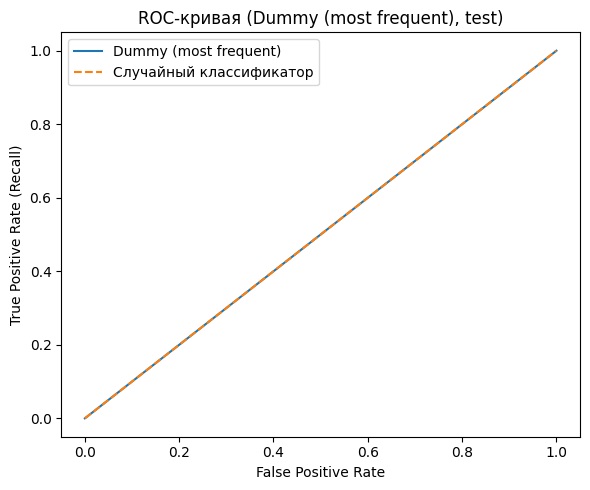

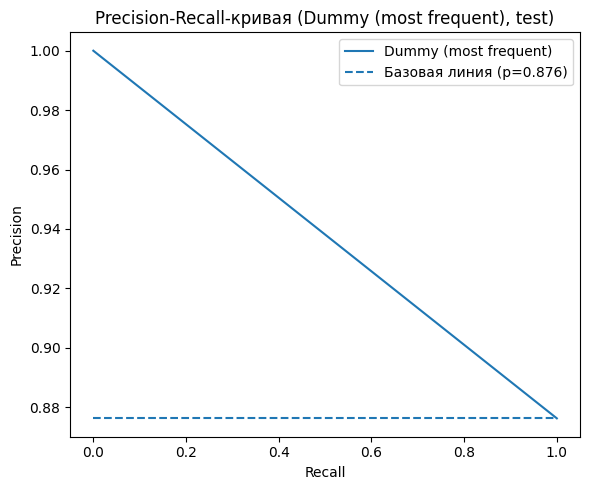

In [26]:
# ------------------------------------------------------------
# Ячейка 3.1 — DummyClassifier (самый частый класс)
# ------------------------------------------------------------

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", dummy_clf),
    ]
)

baseline_results["Dummy_most_frequent"] = evaluate_binary_model(
    model=dummy_pipeline,
    model_name="Dummy (most frequent)",
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test,
    plots_dir=PLOTS_DIR,
    threshold=0.5,
)


[INFO] Обучение модели: LogReg (plain)
[METRICS] LogReg (plain) — validation:
   threshold : 0.5000
   accuracy  : 0.8919
   f1        : 0.9411
   precision : 0.9003
   recall    : 0.9857
   roc_auc   : 0.8134
   pr_auc    : 0.9588


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


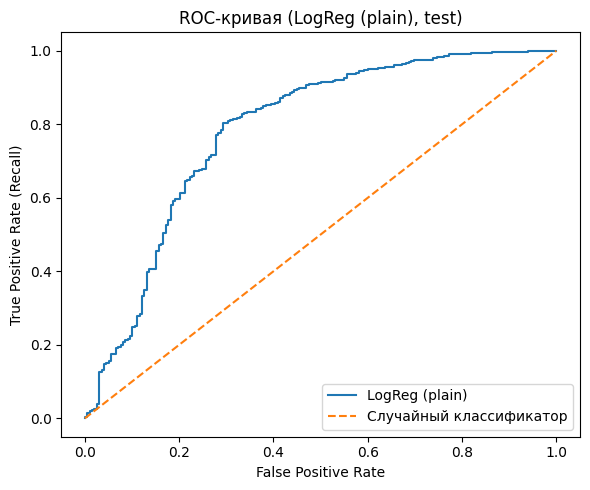

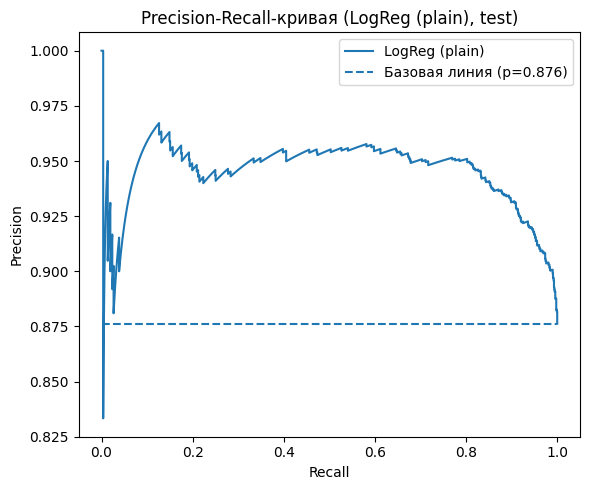


[INFO] Обучение модели: LogReg (balanced)
[METRICS] LogReg (balanced) — validation:
   threshold : 0.5000
   accuracy  : 0.7419
   f1        : 0.8342
   precision : 0.9541
   recall    : 0.7411
   roc_auc   : 0.8084
   pr_auc    : 0.9576


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


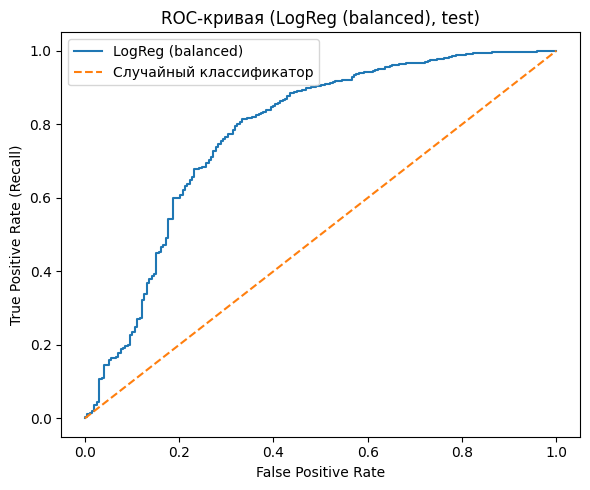

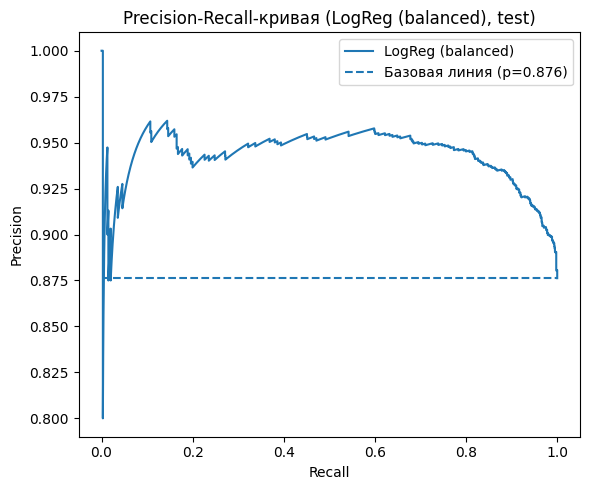

In [27]:
# ------------------------------------------------------------
# Ячейка 3.2 — Логистическая регрессия (обычная и с балансировкой)
# ------------------------------------------------------------

# 1) Логистическая регрессия без учёта дисбаланса
logreg_plain = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=1000,
    n_jobs=-1,
)

logreg_plain_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", logreg_plain),
    ]
)

baseline_results["LogReg_plain"] = evaluate_binary_model(
    model=logreg_plain_pipeline,
    model_name="LogReg (plain)",
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test,
    plots_dir=PLOTS_DIR,
    threshold=0.5,
)

# 2) Логистическая регрессия с учётом дисбаланса классов
logreg_bal = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
)

logreg_bal_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", logreg_bal),
    ]
)

baseline_results["LogReg_balanced"] = evaluate_binary_model(
    model=logreg_bal_pipeline,
    model_name="LogReg (balanced)",
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test,
    plots_dir=PLOTS_DIR,
    threshold=0.5,
)

In [28]:
# ------------------------------------------------------------
# Ячейка 3.3 — Сводная таблица метрик и сохранение артефактов
# ------------------------------------------------------------

# Преобразуем baseline_results в таблицу
rows = []
for model_name, res in baseline_results.items():
    for split_name in ["train", "valid", "test"]:
        metrics = res[split_name]
        row = {
            "model": model_name,
            "split": split_name,
        }
        row.update(metrics)
        rows.append(row)

metrics_df = pd.DataFrame(rows)

print("\n[INFO] Сводная таблица метрик базовых моделей:")
display(metrics_df)

# Сохраняем в CSV и JSON
os.makedirs(REPORTS_DIR, exist_ok=True)

metrics_csv_path = os.path.join(REPORTS_DIR, "metrics_baselines.csv")
metrics_df.to_csv(metrics_csv_path, index=False, encoding="utf-8-sig")

metrics_json_path = os.path.join(REPORTS_DIR, "metrics_baselines.json")
with open(metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(baseline_results, f, indent=2, ensure_ascii=False)

print("\n[INFO] Метрики базовых моделей сохранены в:")
print("   CSV :", metrics_csv_path)
print("   JSON:", metrics_json_path)


[INFO] Сводная таблица метрик базовых моделей:


model  split  threshold  accuracy        f1  precision  \
0  Dummy_most_frequent  train        0.5  0.876667  0.934281   0.876667   
1  Dummy_most_frequent  valid        0.5  0.876250  0.934044   0.876250   
2  Dummy_most_frequent   test        0.5  0.876250  0.934044   0.876250   
3         LogReg_plain  train        0.5  0.898333  0.944809   0.901381   
4         LogReg_plain  valid        0.5  0.891875  0.941096   0.900326   
5         LogReg_plain   test        0.5  0.889375  0.940263   0.892377   
6      LogReg_balanced  train        0.5  0.727708  0.824210   0.949489   
7      LogReg_balanced  valid        0.5  0.741875  0.834203   0.954086   
8      LogReg_balanced   test        0.5  0.735625  0.830189   0.949495   

     recall   roc_auc    pr_auc   tn   fp    fn    tp  support_neg  \
0  1.000000  0.500000  0.876667    0  592     0  4208          592   
1  1.000000  0.500000  0.876250    0  198     0  1402          198   
2  1.000000  0.500000  0.876250    0  198     0  1402          198   
3  0.992633  0.799448  0.956383  135  457    31  4177          592   
4  0.985735  0.813376  0.958805   45  153    20  1382          198   
5  0.993581  0.783729  0.945079   30  168     9  1393          198   
6  0.728137  0.800393  0.957323  429  163  1144  3064          592   
7  0.741084  0.808398  0.957577  148   50   363  1039          198   
8  0.737518  0.777050  0.943216  143   55   368  1034          198   

   support_pos  
0         4208  
1         1402  
2         1402  
3         4208  
4         1402  
5         1402  
6         4208  
7         1402  
8         1402


[INFO] Метрики базовых моделей сохранены в:
   CSV : /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_baselines.csv
   JSON: /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_baselines.json


## Этап 4. Продвинутые ML-модели (ансамбли деревьев)

На этом этапе мы:
- оцениваем степень дисбаланса классов и подбираем коэффициент для бустинга;
- обучаем Random Forest с небольшим RandomizedSearchCV по гиперпараметрам;
- обучаем XGBoost (градиентный бустинг по деревьям) с лёгким поиском по параметрам;
- считаем метрики на train / valid / test (тем же пайплайном evaluate_binary_model, что и на этапе 3);
- анализируем важности признаков и строим частичные зависимости (Partial Dependence) для ключевых факторов;
- сохраняем результаты (метрики, важности, графики) в артефакты для дальнейшего использования.


In [29]:
# ============================================================
# ЭТАП 4. ПРОДВИНУТЫЕ ML-МОДЕЛИ (АНСАМБЛИ ДЕРЕВЬЕВ)
# Требуется, чтобы этапы 0–3 были выполнены.
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay

# XGBoost
from xgboost import XGBClassifier

plt.style.use("default")

advanced_results: dict[str, dict] = {}

# ------------------------------------------------------------
# Ячейка 4.0 — оценка дисбаланса классов
# ------------------------------------------------------------

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
neg_ratio = neg_count / (neg_count + pos_count)
pos_ratio = pos_count / (neg_count + pos_count)

print(f"[INFO] Обучающая выборка: всего {len(y_train)}")
print(f"   Нулевой класс (0): {neg_count} ({neg_ratio*100:.2f}%)")
print(f"   Единичный класс (1): {pos_count} ({pos_ratio*100:.2f}%)")

# Для XGBoost будем использовать scale_pos_weight = n_neg / n_pos,
# чтобы относительно усилить вклад редкого класса (0)
scale_pos_weight = neg_count / pos_count
print(f"[INFO] Рекомендуемый scale_pos_weight для XGBoost: {scale_pos_weight:.4f}")

[INFO] Обучающая выборка: всего 4800
   Нулевой класс (0): 592 (12.33%)
   Единичный класс (1): 4208 (87.67%)
[INFO] Рекомендуемый scale_pos_weight для XGBoost: 0.1407



[INFO] Запуск RandomizedSearchCV для Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

[INFO] Лучшие параметры для Random Forest:
{'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 8}
[INFO] Лучший score (cv average_precision): 0.9546

[INFO] Обучение модели: RandomForest
[METRICS] RandomForest — validation:
   threshold : 0.5000
   accuracy  : 0.9094
   f1        : 0.9496
   precision : 0.9267
   recall    : 0.9736
   roc_auc   : 0.8326
   pr_auc    : 0.9593


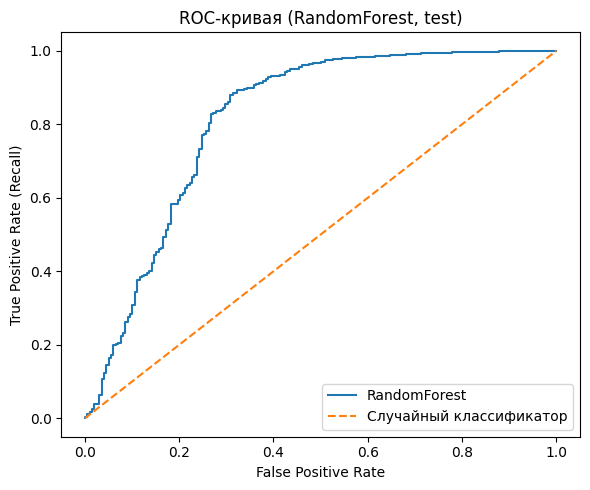

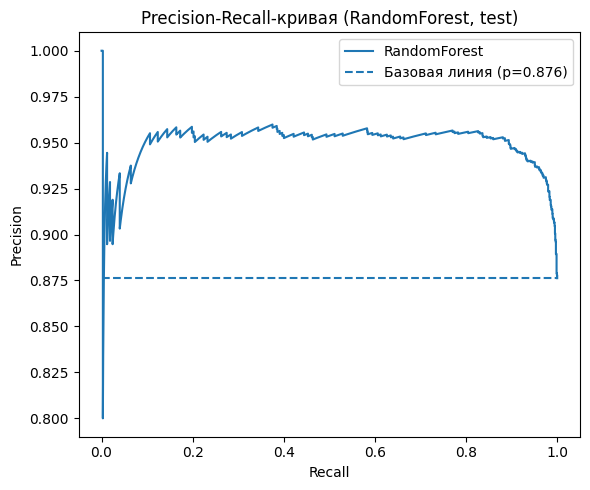

In [30]:
# ------------------------------------------------------------
# Ячейка 4.1 — Random Forest + RandomizedSearchCV
# ------------------------------------------------------------

rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",   # компенсируем дисбаланс
    random_state=42,
    n_jobs=-1,
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", rf_base),
    ]
)

rf_param_distributions = {
    "clf__n_estimators": [150, 200, 300],
    "clf__max_depth": [None, 5, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.5],
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=15,
    scoring="average_precision",   # PR-AUC чувствительна к дисбалансу
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42,
)

print("\n[INFO] Запуск RandomizedSearchCV для Random Forest...")
rf_search.fit(X_train, y_train)

print("\n[INFO] Лучшие параметры для Random Forest:")
print(rf_search.best_params_)
print(f"[INFO] Лучший score (cv average_precision): {rf_search.best_score_:.4f}")

rf_best_pipeline = rf_search.best_estimator_

# Оцениваем с помощью общей функции из этапа 3
advanced_results["RandomForest"] = evaluate_binary_model(
    model=rf_best_pipeline,
    model_name="RandomForest",
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test,
    plots_dir=PLOTS_DIR,
    threshold=0.5,
)


[INFO] Запуск RandomizedSearchCV для XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

[INFO] Лучшие параметры для XGBoost:
{'clf__subsample': 0.7, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.7}
[INFO] Лучший score (cv average_precision): 0.9551

[INFO] Обучение модели: XGBoost
[METRICS] XGBoost — validation:
   threshold : 0.5000
   accuracy  : 0.8538
   f1        : 0.9127
   precision : 0.9570
   recall    : 0.8723
   roc_auc   : 0.8439
   pr_auc    : 0.9613


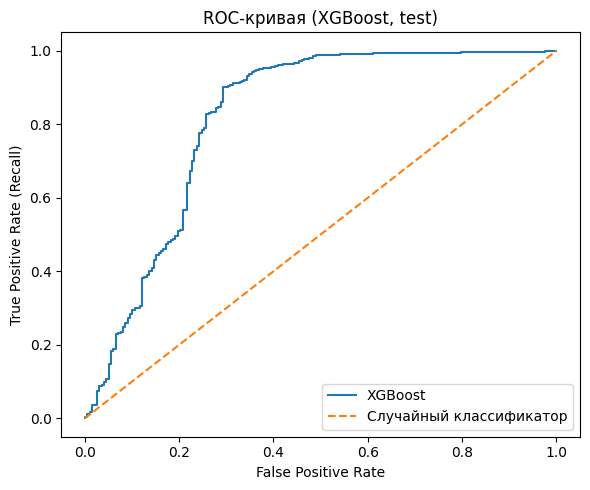

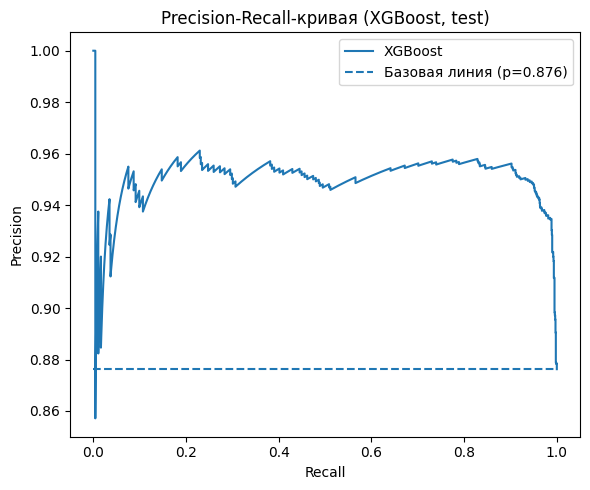

In [31]:
# ------------------------------------------------------------
# Ячейка 4.2 — XGBoost + RandomizedSearchCV
# ------------------------------------------------------------

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",    # быстрый и экономичный по памяти
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", xgb_base),
    ]
)

xgb_param_distributions = {
    "clf__n_estimators": [200, 300, 400],
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    n_iter=15,
    scoring="average_precision",
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42,
)

print("\n[INFO] Запуск RandomizedSearchCV для XGBoost...")
xgb_search.fit(X_train, y_train)

print("\n[INFO] Лучшие параметры для XGBoost:")
print(xgb_search.best_params_)
print(f"[INFO] Лучший score (cv average_precision): {xgb_search.best_score_:.4f}")

xgb_best_pipeline = xgb_search.best_estimator_

advanced_results["XGBoost"] = evaluate_binary_model(
    model=xgb_best_pipeline,
    model_name="XGBoost",
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test,
    plots_dir=PLOTS_DIR,
    threshold=0.5,
)

In [32]:
# ------------------------------------------------------------
# Ячейка 4.3 — сводная таблица метрик ансамблей
# ------------------------------------------------------------

rows = []
for model_name, res in advanced_results.items():
    for split_name in ["train", "valid", "test"]:
        metrics = res[split_name]
        row = {
            "model": model_name,
            "split": split_name,
        }
        row.update(metrics)
        rows.append(row)

adv_metrics_df = pd.DataFrame(rows)

print("\n[INFO] Сводная таблица метрик ансамблей:")
display(adv_metrics_df)

adv_metrics_csv_path = os.path.join(REPORTS_DIR, "metrics_ensembles.csv")
adv_metrics_df.to_csv(adv_metrics_csv_path, index=False, encoding="utf-8-sig")

adv_metrics_json_path = os.path.join(REPORTS_DIR, "metrics_ensembles.json")
with open(adv_metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(advanced_results, f, indent=2, ensure_ascii=False)

print("\n[INFO] Метрики ансамблей сохранены в:")
print("   CSV :", adv_metrics_csv_path)
print("   JSON:", adv_metrics_json_path)


[INFO] Сводная таблица метрик ансамблей:


model  split  threshold  accuracy        f1  precision    recall  \
0  RandomForest  train        0.5  0.965625  0.980600   0.970444  0.990970   
1  RandomForest  valid        0.5  0.909375  0.949565   0.926680  0.973609   
2  RandomForest   test        0.5  0.914375  0.952281   0.930565  0.975036   
3       XGBoost  train        0.5  0.875208  0.925525   0.970535  0.884506   
4       XGBoost  valid        0.5  0.853750  0.912687   0.956964  0.872325   
5       XGBoost   test        0.5  0.836875  0.901769   0.954582  0.854494   

    roc_auc    pr_auc   tn   fp   fn    tp  support_neg  support_pos  
0  0.982550  0.997396  465  127   38  4170          592         4208  
1  0.832595  0.959316   90  108   37  1365          198         1402  
2  0.813412  0.949778   96  102   35  1367          198         1402  
3  0.929994  0.987366  479  113  486  3722          592         4208  
4  0.843906  0.961337  143   55  179  1223          198         1402  
5  0.817951  0.950307  141   57  204  1198          198         1402


[INFO] Метрики ансамблей сохранены в:
   CSV : /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_ensembles.csv
   JSON: /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_ensembles.json



[INFO] Важности признаков RandomForest сохранены в: /content/drive/MyDrive/digital_marketing_conversion/reports/feature_importances_randomforest.csv


feature  importance
18          num__EngagementScore    0.154265
2                   num__AdSpend    0.070817
11        num__PreviousPurchases    0.066319
3          num__ClickThroughRate    0.065312
12            num__LoyaltyPoints    0.060984
6             num__PagesPerVisit    0.059083
4            num__ConversionRate    0.055248
7                num__TimeOnSite    0.050795
17       num__LoyaltyPerPurchase    0.044960
9                num__EmailOpens    0.041211
14          num__SocialShareRate    0.037602
10              num__EmailClicks    0.037355
15             num__CostPerVisit    0.035793
16        num__CostPerEmailClick    0.034748
5             num__WebsiteVisits    0.033929
8              num__SocialShares    0.031233
13      num__EmailEngagementRate    0.030303
1                    num__Income    0.027941
0                       num__Age    0.023907
25  cat__CampaignType_Conversion    0.017850

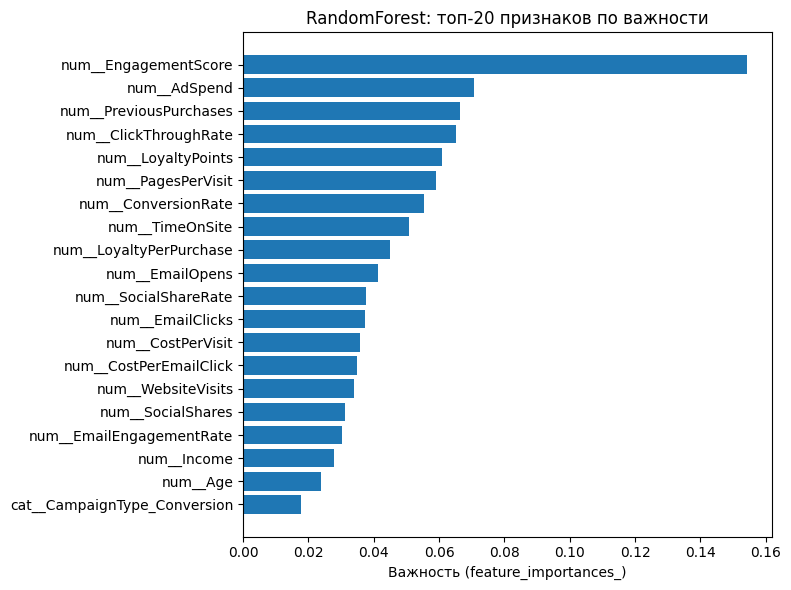

[INFO] График важностей RandomForest сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/rf_feature_importances_top20.png

[INFO] Важности признаков XGBoost сохранены в: /content/drive/MyDrive/digital_marketing_conversion/reports/feature_importances_xgboost.csv


feature  importance
18           num__EngagementScore    0.084007
11         num__PreviousPurchases    0.075885
10               num__EmailClicks    0.051973
12             num__LoyaltyPoints    0.049718
4             num__ConversionRate    0.046893
2                    num__AdSpend    0.045301
25   cat__CampaignType_Conversion    0.044793
3           num__ClickThroughRate    0.043561
7                 num__TimeOnSite    0.040813
9                 num__EmailOpens    0.040292
5              num__WebsiteVisits    0.039200
6              num__PagesPerVisit    0.038645
17        num__LoyaltyPerPurchase    0.035549
8               num__SocialShares    0.030916
21  cat__CampaignChannel_Referral    0.030830
13       num__EmailEngagementRate    0.028710
14           num__SocialShareRate    0.028093
16         num__CostPerEmailClick    0.028082
15              num__CostPerVisit    0.026994
20       cat__CampaignChannel_PPC    0.026516

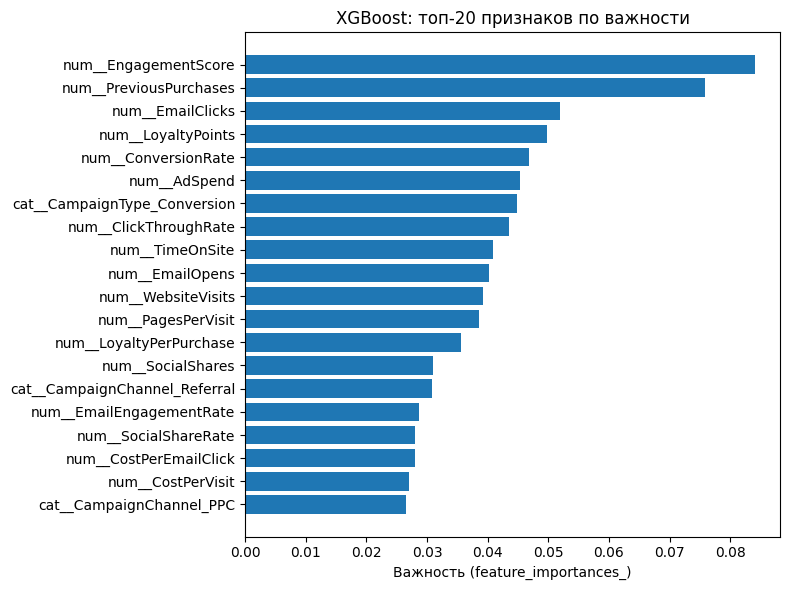

[INFO] График важностей XGBoost сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/xgb_feature_importances_top20.png


In [33]:
# ------------------------------------------------------------
# Ячейка 4.4 — важности признаков и частичные зависимости
# ------------------------------------------------------------

def get_feature_names_from_preprocess(fitted_preprocess, numeric_features, categorical_features):
    """
    Возвращает список имён признаков после ColumnTransformer.
    """
    try:
        # sklearn >= 1.0
        return fitted_preprocess.get_feature_names_out().tolist()
    except AttributeError:
        # ручной fallback
        num_names = numeric_features
        cat_ohe = []
        if "cat" in fitted_preprocess.named_transformers_:
            ohe = fitted_preprocess.named_transformers_["cat"]["onehot"]
            cat_ohe = ohe.get_feature_names_out(categorical_features).tolist()
        return num_names + cat_ohe


# === 4.4.1 Важности признаков для RandomForest ===
rf_pre = rf_best_pipeline.named_steps["preprocess"]
rf_clf = rf_best_pipeline.named_steps["clf"]

rf_feature_names = get_feature_names_from_preprocess(
    rf_pre, NUMERIC_FEATURES, CATEGORICAL_FEATURES
)

rf_importances = rf_clf.feature_importances_
rf_imp_df = pd.DataFrame(
    {"feature": rf_feature_names, "importance": rf_importances}
).sort_values("importance", ascending=False)

rf_imp_csv_path = os.path.join(REPORTS_DIR, "feature_importances_randomforest.csv")
rf_imp_df.to_csv(rf_imp_csv_path, index=False, encoding="utf-8-sig")
print("\n[INFO] Важности признаков RandomForest сохранены в:", rf_imp_csv_path)
display(rf_imp_df.head(20))

# График топ-20 признаков
top_k = 20
rf_top = rf_imp_df.head(top_k).iloc[::-1]  # для красивой ориентации по вертикали

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(rf_top["feature"], rf_top["importance"])
ax.set_title("RandomForest: топ-20 признаков по важности")
ax.set_xlabel("Важность (feature_importances_)")
plt.tight_layout()

rf_imp_plot_path = os.path.join(PLOTS_DIR, "rf_feature_importances_top20.png")
plt.savefig(rf_imp_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График важностей RandomForest сохранён в:", rf_imp_plot_path)


# === 4.4.2 Важности признаков для XGBoost ===
xgb_pre = xgb_best_pipeline.named_steps["preprocess"]
xgb_clf = xgb_best_pipeline.named_steps["clf"]

xgb_feature_names = get_feature_names_from_preprocess(
    xgb_pre, NUMERIC_FEATURES, CATEGORICAL_FEATURES
)

xgb_importances = xgb_clf.feature_importances_
xgb_imp_df = pd.DataFrame(
    {"feature": xgb_feature_names, "importance": xgb_importances}
).sort_values("importance", ascending=False)

xgb_imp_csv_path = os.path.join(REPORTS_DIR, "feature_importances_xgboost.csv")
xgb_imp_df.to_csv(xgb_imp_csv_path, index=False, encoding="utf-8-sig")
print("\n[INFO] Важности признаков XGBoost сохранены в:", xgb_imp_csv_path)
display(xgb_imp_df.head(20))

xgb_top = xgb_imp_df.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(xgb_top["feature"], xgb_top["importance"])
ax.set_title("XGBoost: топ-20 признаков по важности")
ax.set_xlabel("Важность (feature_importances_)")
plt.tight_layout()

xgb_imp_plot_path = os.path.join(PLOTS_DIR, "xgb_feature_importances_top20.png")
plt.savefig(xgb_imp_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График важностей XGBoost сохранён в:", xgb_imp_plot_path)


[INFO] Признаки для Partial Dependence: ['AdSpend', 'ConversionRate', 'WebsiteVisits', 'PreviousPurchases']


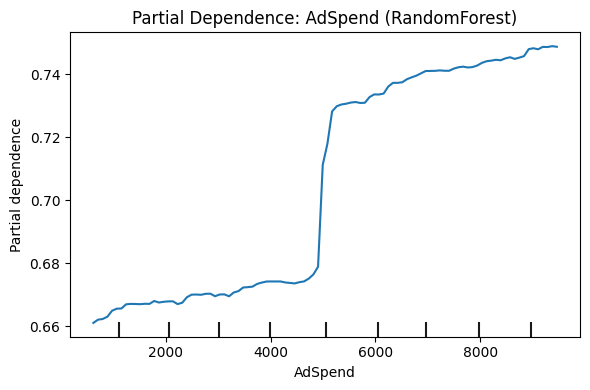

[INFO] Partial dependence для признака AdSpend сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/pdp_randomforest_AdSpend.png


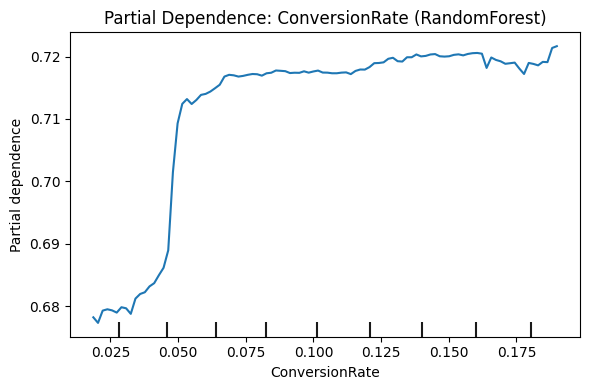

[INFO] Partial dependence для признака ConversionRate сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/pdp_randomforest_ConversionRate.png


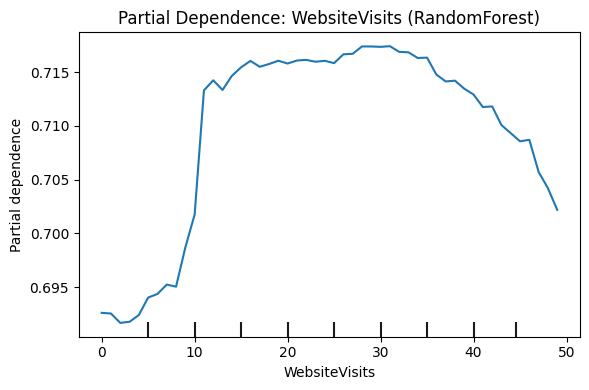

[INFO] Partial dependence для признака WebsiteVisits сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/pdp_randomforest_WebsiteVisits.png


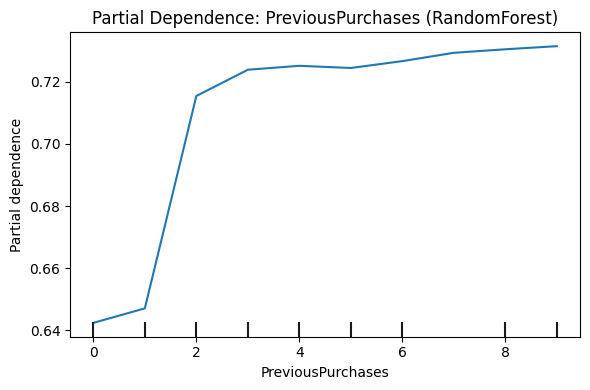

[INFO] Partial dependence для признака PreviousPurchases сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/pdp_randomforest_PreviousPurchases.png


In [34]:
# ------------------------------------------------------------
# Ячейка 4.5 — Partial Dependence для ключевых признаков
# ------------------------------------------------------------

# Будем смотреть зависимости для нескольких числовых признаков,
# которые точно есть в исходном датасете
pdp_features_candidates = [
    "AdSpend",
    "ConversionRate",
    "WebsiteVisits",
    "PreviousPurchases",
]

pdp_features = [f for f in pdp_features_candidates if f in X_train.columns]
print("\n[INFO] Признаки для Partial Dependence:", pdp_features)

os.makedirs(PLOTS_DIR, exist_ok=True)

for feat in pdp_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        rf_best_pipeline,
        X_train,
        features=[feat],
        kind="average",
        ax=ax,
    )
    ax.set_title(f"Partial Dependence: {feat} (RandomForest)")
    plt.tight_layout()

    pdp_path = os.path.join(PLOTS_DIR, f"pdp_randomforest_{feat}.png")
    plt.savefig(pdp_path, dpi=150)
    plt.show()
    plt.close()

    print(f"[INFO] Partial dependence для признака {feat} сохранён в:", pdp_path)

## Этап 5. Модель глубокого обучения (MLP)

На этом этапе мы:
- подготавливаем данные для нейросети (фиксируем `preprocess`, получаем плотные матрицы признаков);
- строим полносвязную нейросеть (MLP) с двумя–тремя скрытыми слоями, BatchNorm и Dropout;
- обучаем модель с ранней остановкой (EarlyStopping) и адаптивным шагом (ReduceLROnPlateau);
- оцениваем качество на train / valid / test по тем же метрикам, что и для других моделей;
- считаем простую пермутационную важность признаков для MLP и сохраняем результаты в артефакты.

In [35]:
# ============================================================
# ЭТАП 5.0 — подготовка данных для DL и импорт TensorFlow
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.base import clone

# При необходимости можно доустановить TensorFlow (в Colab обычно уже есть)
try:
    import tensorflow as tf
except ImportError:
    !pip install -q tensorflow
    import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("[INFO] Версия TensorFlow:", tf.__version__)

# Клоним препроцессор, чтобы отдельно фитить его под DL,
# не ломая уже обученные пайплайны sklearn
preprocess_dl = clone(preprocess)

# Фитим на обучающей выборке и трансформируем все сплиты
X_train_dl = preprocess_dl.fit_transform(X_train)
X_valid_dl = preprocess_dl.transform(X_valid)
X_test_dl = preprocess_dl.transform(X_test)

y_train_dl = y_train.values.astype("float32")
y_valid_dl = y_valid.values.astype("float32")
y_test_dl = y_test.values.astype("float32")

print("\n[SHAPE] Формы массивов для DL:")
print("   X_train_dl:", X_train_dl.shape, " | y_train_dl:", y_train_dl.shape)
print("   X_valid_dl:", X_valid_dl.shape, " | y_valid_dl:", y_valid_dl.shape)
print("   X_test_dl :", X_test_dl.shape,  " | y_test_dl :", y_test_dl.shape)

input_dim = X_train_dl.shape[1]
print("\n[INFO] Размер входного слоя MLP:", input_dim)

# Сохраним описание feature-space именно для DL-ветки
from sklearn.preprocessing import OneHotEncoder, RobustScaler

def get_feature_names_from_preprocess(fitted_preprocess, numeric_features, categorical_features):
    try:
        return fitted_preprocess.get_feature_names_out().tolist()
    except Exception:
        num_names = numeric_features
        cat_names = []
        if "cat" in fitted_preprocess.named_transformers_:
            ohe = fitted_preprocess.named_transformers_["cat"]["onehot"]
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        return num_names + cat_names

dl_feature_names = get_feature_names_from_preprocess(
    preprocess_dl, NUMERIC_FEATURES, CATEGORICAL_FEATURES
)

dl_feature_space = {
    "input_dim": int(input_dim),
    "feature_names": dl_feature_names,
}

dl_feature_space_path = os.path.join(DATA_DIR, "dl_feature_space.json")
with open(dl_feature_space_path, "w", encoding="utf-8") as f:
    json.dump(dl_feature_space, f, indent=2, ensure_ascii=False)

print("[INFO] DL feature_space сохранён в:", dl_feature_space_path)

[INFO] Версия TensorFlow: 2.19.0

[SHAPE] Формы массивов для DL:
   X_train_dl: (4800, 27)  | y_train_dl: (4800,)
   X_valid_dl: (1600, 27)  | y_valid_dl: (1600,)
   X_test_dl : (1600, 27)  | y_test_dl : (1600,)

[INFO] Размер входного слоя MLP: 27
[INFO] DL feature_space сохранён в: /content/drive/MyDrive/digital_marketing_conversion/data/dl_feature_space.json


In [36]:
# ============================================================
# ЭТАП 5.1 — определение архитектуры MLP
# ============================================================

def build_mlp_model(
    input_dim: int,
    hidden_units: list[int] = [128, 64, 32],
    dropout_rate: float = 0.3,
) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="features")
    x = inputs

    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation=None, name=f"dense_{i+1}")(x)
        x = layers.BatchNormalization(name=f"bn_{i+1}")(x)
        x = layers.Activation("relu", name=f"relu_{i+1}")(x)
        x = layers.Dropout(dropout_rate, name=f"dropout_{i+1}")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mlp_conversion")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model


mlp_model = build_mlp_model(input_dim=input_dim)

mlp_model.summary()

Model: "mlp_conversion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,401 (56.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
19/19 - 18s - 965ms/step - auc: 0.5184 - loss: 0.5900 - precision: 0.8806 - recall: 0.7695 - val_auc: 0.6437 - val_loss: 0.6473 - val_precision: 0.9035 - val_recall: 0.7746 - learning_rate: 1.0000e-03
Epoch 2/100
19/19 - 7s - 357ms/step - auc: 0.6065 - loss: 0.4842 - precision: 0.8909 - recall: 0.8871 - val_auc: 0.7191 - val_loss: 0.6052 - val_precision: 0.9109 - val_recall: 0.8388 - learning_rate: 1.0000e-03
Epoch 3/100
19/19 - 0s - 25ms/step - auc: 0.6448 - loss: 0.4253 - precision: 0.8896 - recall: 0.9420 - val_auc: 0.7499 - val_loss: 0.5390 - val_precision: 0.9009 - val_recall: 0.9272 - learning_rate: 1.0000e-03
Epoch 4/100
19/19 - 0s - 26ms/step - auc: 0.6546 - loss: 0.3948 - precision: 0.8854 - recall: 0.9660 - val_auc: 0.7698 - val_loss: 0.4830 - val_precision: 0.8954 - val_recall: 0.9643 - learning_rate: 1.0000e-03
Epoch 5/100
19/19 - 0s - 25ms/step - auc: 0.6812 - loss: 0.3776 - precision: 0.8862 - recall: 0.9677 - val_auc: 0.7753 - val_loss: 0.4554 - val_precision

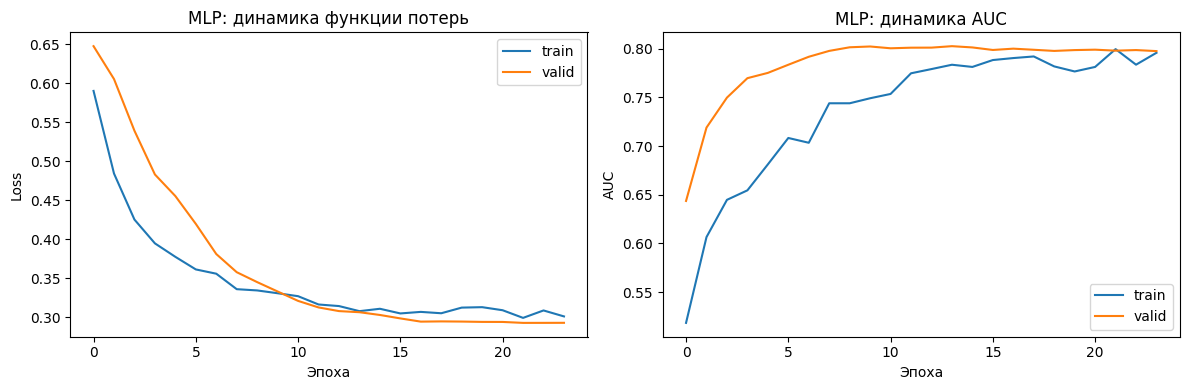

[INFO] График истории обучения MLP сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/mlp_training_history.png


In [37]:
# ============================================================
# ЭТАП 5.2 — обучение MLP с ранней остановкой
# ============================================================

BATCH_SIZE = 256
EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=10,
        mode="max",
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        factor=0.5,
        patience=5,
        mode="max",
        verbose=1,
        min_lr=1e-5,
    ),
]

history = mlp_model.fit(
    X_train_dl,
    y_train_dl,
    validation_data=(X_valid_dl, y_valid_dl),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
)

# --- графики истории обучения ---
import matplotlib.pyplot as plt

history_dict = history.history

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Потери
axes[0].plot(history_dict["loss"], label="train")
axes[0].plot(history_dict["val_loss"], label="valid")
axes[0].set_title("MLP: динамика функции потерь")
axes[0].set_xlabel("Эпоха")
axes[0].set_ylabel("Loss")
axes[0].legend()

# AUC
axes[1].plot(history_dict["auc"], label="train")
axes[1].plot(history_dict["val_auc"], label="valid")
axes[1].set_title("MLP: динамика AUC")
axes[1].set_xlabel("Эпоха")
axes[1].set_ylabel("AUC")
axes[1].legend()

plt.tight_layout()
mlp_history_plot_path = os.path.join(PLOTS_DIR, "mlp_training_history.png")
plt.savefig(mlp_history_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График истории обучения MLP сохранён в:", mlp_history_plot_path)

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[METRICS] MLP — validation:
   threshold : 0.5000
   accuracy  : 0.8912
   f1        : 0.9396
   precision : 0.9149
   recall    : 0.9658
   roc_auc   : 0.8023
   pr_auc    : 0.9549


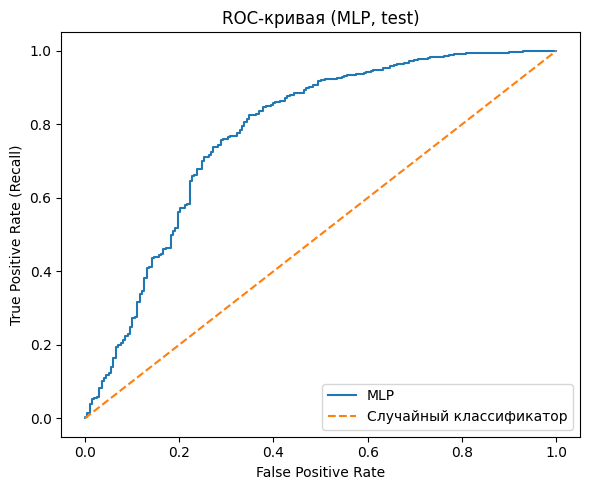

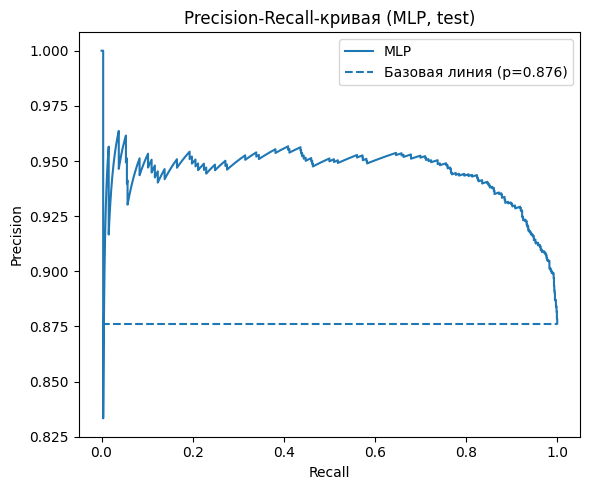


[INFO] Метрики MLP:


model  split  threshold  accuracy        f1  precision    recall   roc_auc  \
0   MLP  train        0.5  0.899167  0.944033   0.919369  0.970057  0.833085   
1   MLP  valid        0.5  0.891250  0.939625   0.914865  0.965763  0.802267   
2   MLP   test        0.5  0.890625  0.939759   0.908184  0.973609  0.778131   

     pr_auc   tn   fp   fn    tp  support_neg  support_pos  
0  0.966714  234  358  126  4082          592         4208  
1  0.954893   72  126   48  1354          198         1402  
2  0.945024   60  138   37  1365          198         1402


[INFO] Метрики MLP сохранены в:
   CSV : /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_dl_mlp.csv
   JSON: /content/drive/MyDrive/digital_marketing_conversion/reports/metrics_dl_mlp.json


In [38]:
# ============================================================
# ЭТАП 5.3 — оценка MLP на train / valid / test
# ============================================================

def evaluate_mlp_model(
    model: keras.Model,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    threshold: float = 0.5,
) -> dict:
    # Прогнозы вероятностей
    proba_train = model.predict(X_train).ravel()
    proba_valid = model.predict(X_valid).ravel()
    proba_test = model.predict(X_test).ravel()

    metrics_train = _compute_basic_metrics(y_train, proba_train, threshold)
    metrics_valid = _compute_basic_metrics(y_valid, proba_valid, threshold)
    metrics_test = _compute_basic_metrics(y_test, proba_test, threshold)

    print("\n[METRICS] MLP — validation:")
    for k, v in metrics_valid.items():
        if k in ["tn", "fp", "fn", "tp", "support_neg", "support_pos"]:
            continue
        print(f"   {k:10s}: {v:.4f}" if isinstance(v, float) else f"   {k:10s}: {v}")

    # ROC/PR-кривые на тесте
    plot_paths = plot_roc_pr_curves(
        y_true=y_test,
        y_proba=proba_test,
        model_name="MLP",
        split_name="test",
        plots_dir=PLOTS_DIR,
    )

    return {
        "train": metrics_train,
        "valid": metrics_valid,
        "test": metrics_test,
        "plots": plot_paths,
    }


dl_results = {}
dl_results["MLP"] = evaluate_mlp_model(
    model=mlp_model,
    X_train=X_train_dl,
    y_train=y_train_dl,
    X_valid=X_valid_dl,
    y_valid=y_valid_dl,
    X_test=X_test_dl,
    y_test=y_test_dl,
    threshold=0.5,
)

# --- сводная таблица и сохранение ---
rows = []
for model_name, res in dl_results.items():
    for split_name in ["train", "valid", "test"]:
        metrics = res[split_name]
        row = {
            "model": model_name,
            "split": split_name,
        }
        row.update(metrics)
        rows.append(row)

dl_metrics_df = pd.DataFrame(rows)
print("\n[INFO] Метрики MLP:")
display(dl_metrics_df)

dl_metrics_csv_path = os.path.join(REPORTS_DIR, "metrics_dl_mlp.csv")
dl_metrics_df.to_csv(dl_metrics_csv_path, index=False, encoding="utf-8-sig")

dl_metrics_json_path = os.path.join(REPORTS_DIR, "metrics_dl_mlp.json")
with open(dl_metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(dl_results, f, indent=2, ensure_ascii=False)

print("\n[INFO] Метрики MLP сохранены в:")
print("   CSV :", dl_metrics_csv_path)
print("   JSON:", dl_metrics_json_path)


[INFO] Расчёт пермутационной важности для MLP (по валидационной выборке)...
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[PI] Обработано признаков: 10/27
[PI] Обработано признаков: 20/27
[PI] Обработано признаков: 27/27
[INFO] Пермутационная важность MLP сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/feature_permutation_importance_mlp.csv


feature  importance
18               num__EngagementScore    0.017720
12                 num__LoyaltyPoints    0.006868
7                     num__TimeOnSite    0.006127
14               num__SocialShareRate    0.005615
25       cat__CampaignType_Conversion    0.005114
3               num__ClickThroughRate    0.005078
2                        num__AdSpend    0.002285
11             num__PreviousPurchases    0.002254
21      cat__CampaignChannel_Referral    0.001834
9                     num__EmailOpens    0.001407
23  cat__CampaignChannel_Social Media    0.001282
15                  num__CostPerVisit    0.001242
17            num__LoyaltyPerPurchase    0.001167
8                   num__SocialShares    0.001119
20           cat__CampaignChannel_PPC    0.000940
26        cat__CampaignType_Retention    0.000683
19                   cat__Gender_Male    0.000530
6                  num__PagesPerVisit    0.000498
22           cat__CampaignChannel_SEO    0.000449
16             num__CostPerEmailClick    0.000387

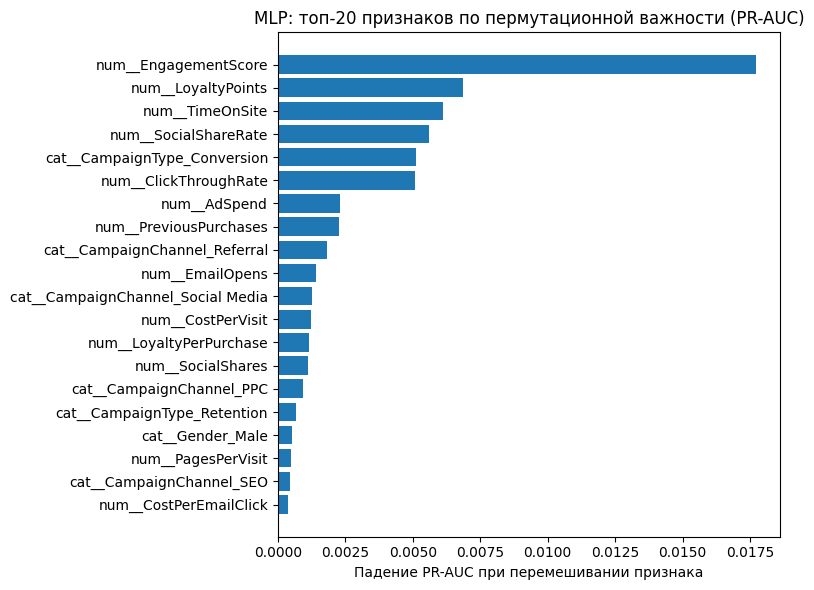

[INFO] График пермутационной важности MLP сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/mlp_permutation_importance_top20.png


In [39]:
# ============================================================
# ЭТАП 5.4 — пермутационная важность признаков для MLP
# ============================================================

from sklearn.metrics import average_precision_score

def permutation_importance_mlp(
    model: keras.Model,
    X: np.ndarray,
    y: np.ndarray,
    feature_names: list[str],
    n_repeats: int = 5,
) -> pd.DataFrame:
    """
    Простая пермутационная важность: считаем падение PR-AUC при перемешивании
    каждого признака.
    """
    rng = np.random.RandomState(42)

    # базовый PR-AUC
    base_proba = model.predict(X).ravel()
    base_score = average_precision_score(y, base_proba)

    importances = []
    n_features = X.shape[1]

    for j in range(n_features):
        scores = []
        for r in range(n_repeats):
            X_permuted = X.copy()
            perm = rng.permutation(X_permuted.shape[0])
            X_permuted[:, j] = X_permuted[perm, j]
            proba_perm = model.predict(X_permuted, verbose=0).ravel()
            score_perm = average_precision_score(y, proba_perm)
            scores.append(score_perm)

        mean_score_perm = float(np.mean(scores))
        importance = base_score - mean_score_perm
        importances.append(importance)

        if (j + 1) % 10 == 0 or j == n_features - 1:
            print(f"[PI] Обработано признаков: {j+1}/{n_features}")

    imp_df = pd.DataFrame(
        {
            "feature": feature_names,
            "importance": importances,
        }
    ).sort_values("importance", ascending=False)

    return imp_df


print("\n[INFO] Расчёт пермутационной важности для MLP (по валидационной выборке)...")
mlp_pi_df = permutation_importance_mlp(
    model=mlp_model,
    X=X_valid_dl,
    y=y_valid_dl,
    feature_names=dl_feature_names,
    n_repeats=5,
)

mlp_pi_csv_path = os.path.join(REPORTS_DIR, "feature_permutation_importance_mlp.csv")
mlp_pi_df.to_csv(mlp_pi_csv_path, index=False, encoding="utf-8-sig")
print("[INFO] Пермутационная важность MLP сохранена в:", mlp_pi_csv_path)

display(mlp_pi_df.head(20))

# График топ-20 признаков
top_k = 20
mlp_top = mlp_pi_df.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(mlp_top["feature"], mlp_top["importance"])
ax.set_title("MLP: топ-20 признаков по пермутационной важности (PR-AUC)")
ax.set_xlabel("Падение PR-AUC при перемешивании признака")
plt.tight_layout()

mlp_pi_plot_path = os.path.join(PLOTS_DIR, "mlp_permutation_importance_top20.png")
plt.savefig(mlp_pi_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График пермутационной важности MLP сохранён в:", mlp_pi_plot_path)

## Этап 6. Анализ порогов, лифт/гейны и упрощённый ROI

На этом этапе мы:
- выбираем «чемпионскую» модель (RandomForest) и считаем для неё вероятности на валидационной и тестовой выборках;
- строим кривые зависимости метрик (F1, precision, recall, доля выбранных клиентов) от порога отсечения;
- автоматически подбираем три сценарных порога:
  - порог максимального F1;
  - порог «высокого recall» (минимум 0.98, максимальный precision);
  - порог «высокого precision» (минимум 0.97, максимальный recall);
- строим кумулятивные гейны и лифт-кривые для тестовой выборки;
- считаем простую модель ROI для нескольких порогов (используя AdSpend как стоимость контакта и заданную пользователем величину выручки за одну конверсию).

In [40]:
# ============================================================
# ЭТАП 6.0 — выбор чемпионской модели и расчёт вероятностей
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

plt.style.use("default")

# Чемпионская модель — RandomForest (можно потом поменять вручную)
champion_name = "RandomForest"
champion_pipeline = rf_best_pipeline  # из этапа 4

print(f"[INFO] Чемпионская модель для анализа порогов: {champion_name}")

# Вероятности класса 1 на валид и тест
proba_valid_rf = champion_pipeline.predict_proba(X_valid)[:, 1]
proba_test_rf = champion_pipeline.predict_proba(X_test)[:, 1]

y_valid_np = y_valid.values
y_test_np = y_test.values

print("[INFO] Примеры вероятностей (valid):", proba_valid_rf[:5])
print("[INFO] Примеры вероятностей (test) :", proba_test_rf[:5])

[INFO] Чемпионская модель для анализа порогов: RandomForest
[INFO] Примеры вероятностей (valid): [0.82554438 0.84025502 0.73062699 0.43885002 0.74700614]
[INFO] Примеры вероятностей (test) : [0.71249828 0.83593594 0.80333282 0.32337317 0.84850629]



[INFO] Пример таблицы по порогам (validation):


threshold  accuracy        f1  precision  recall  positive_rate
0       0.10   0.87625  0.934044    0.87625     1.0            1.0
1       0.11   0.87625  0.934044    0.87625     1.0            1.0
2       0.12   0.87625  0.934044    0.87625     1.0            1.0
3       0.13   0.87625  0.934044    0.87625     1.0            1.0
4       0.14   0.87625  0.934044    0.87625     1.0            1.0

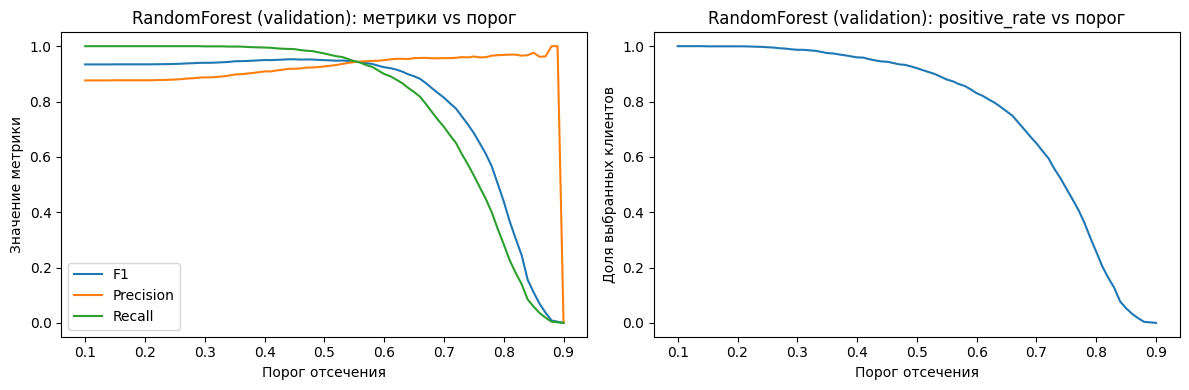

[INFO] График метрик по порогу сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/rf_threshold_metrics_valid.png

[INFO] Выбранные сценарные пороги (по validation):
          best_f1: 0.440
      high_recall: 0.480
   high_precision: 0.850
      default_0_5: 0.500

[INFO] Кривая метрик и сценарные пороги сохранены в:
   curve_valid: /content/drive/MyDrive/digital_marketing_conversion/reports/rf_threshold_curve_valid.csv
   curve_test : /content/drive/MyDrive/digital_marketing_conversion/reports/rf_threshold_curve_test.csv
   scenarios  : /content/drive/MyDrive/digital_marketing_conversion/reports/rf_threshold_scenarios.json


In [41]:
# ============================================================
# ЭТАП 6.1 — кривые F1 / precision / recall по порогу
# ============================================================

def compute_threshold_curve(y_true: np.ndarray, y_proba: np.ndarray, thresholds: np.ndarray) -> pd.DataFrame:
    rows = []
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        pos_rate = y_pred.mean()
        rows.append(
            {
                "threshold": float(thr),
                "accuracy": acc,
                "f1": f1,
                "precision": prec,
                "recall": rec,
                "positive_rate": pos_rate,
            }
        )
    return pd.DataFrame(rows)


thresholds = np.linspace(0.1, 0.9, 81)  # 0.10, 0.11, ..., 0.90

curve_valid = compute_threshold_curve(y_valid_np, proba_valid_rf, thresholds)
curve_test = compute_threshold_curve(y_test_np, proba_test_rf, thresholds)

print("\n[INFO] Пример таблицы по порогам (validation):")
display(curve_valid.head())

# --- графики для валидации ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(curve_valid["threshold"], curve_valid["f1"], label="F1")
ax[0].plot(curve_valid["threshold"], curve_valid["precision"], label="Precision")
ax[0].plot(curve_valid["threshold"], curve_valid["recall"], label="Recall")
ax[0].set_xlabel("Порог отсечения")
ax[0].set_ylabel("Значение метрики")
ax[0].set_title("RandomForest (validation): метрики vs порог")
ax[0].legend()

ax[1].plot(curve_valid["threshold"], curve_valid["positive_rate"])
ax[1].set_xlabel("Порог отсечения")
ax[1].set_ylabel("Доля выбранных клиентов")
ax[1].set_title("RandomForest (validation): positive_rate vs порог")

plt.tight_layout()
thr_curve_plot_path = os.path.join(PLOTS_DIR, "rf_threshold_metrics_valid.png")
plt.savefig(thr_curve_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График метрик по порогу сохранён в:", thr_curve_plot_path)

# --- выбор «оптимальных» порогов по validation ---
# 1) Максимальный F1
idx_best_f1 = curve_valid["f1"].idxmax()
thr_best_f1 = float(curve_valid.loc[idx_best_f1, "threshold"])

# 2) Высокий recall (>= 0.98), максимальный precision
high_recall_mask = curve_valid["recall"] >= 0.98
if high_recall_mask.any():
    high_recall_df = curve_valid[high_recall_mask]
    idx_high_rec = high_recall_df["precision"].idxmax()
    thr_high_recall = float(curve_valid.loc[idx_high_rec, "threshold"])
else:
    thr_high_recall = float(thr_best_f1)

# 3) Высокий precision (>= 0.97), максимальный recall
high_precision_mask = curve_valid["precision"] >= 0.97
if high_precision_mask.any():
    high_precision_df = curve_valid[high_precision_mask]
    idx_high_prec = high_precision_df["recall"].idxmax()
    thr_high_precision = float(curve_valid.loc[idx_high_prec, "threshold"])
else:
    thr_high_precision = float(thr_best_f1)

threshold_scenarios = {
    "best_f1": thr_best_f1,
    "high_recall": thr_high_recall,
    "high_precision": thr_high_precision,
    "default_0_5": 0.5,
}

print("\n[INFO] Выбранные сценарные пороги (по validation):")
for name, thr in threshold_scenarios.items():
    print(f"   {name:>14s}: {thr:.3f}")

# Сохраним кривые и пороги
curve_valid_path = os.path.join(REPORTS_DIR, "rf_threshold_curve_valid.csv")
curve_test_path = os.path.join(REPORTS_DIR, "rf_threshold_curve_test.csv")
curve_valid.to_csv(curve_valid_path, index=False, encoding="utf-8-sig")
curve_test.to_csv(curve_test_path, index=False, encoding="utf-8-sig")

thr_scenarios_path = os.path.join(REPORTS_DIR, "rf_threshold_scenarios.json")
with open(thr_scenarios_path, "w", encoding="utf-8") as f:
    json.dump(threshold_scenarios, f, indent=2, ensure_ascii=False)

print("\n[INFO] Кривая метрик и сценарные пороги сохранены в:")
print("   curve_valid:", curve_valid_path)
print("   curve_test :", curve_test_path)
print("   scenarios  :", thr_scenarios_path)


[INFO] Базовая доля положительного класса на тесте: 0.8762
[INFO] Таблица лифта (первые строки):


bin  count  positives     rate      lift  cum_count  cum_positives  \
0    1    160        152  0.95000  1.084165        160            152   
1    2    160        153  0.95625  1.091298        320            305   
2    3    160        154  0.96250  1.098431        480            459   
3    4    160        152  0.95000  1.084165        640            611   
4    5    160        153  0.95625  1.091298        800            764   

   cum_rate  cum_gain  population_share  
0  0.950000  0.108417               0.1  
1  0.953125  0.217546               0.2  
2  0.956250  0.327389               0.3  
3  0.954688  0.435806               0.4  
4  0.955000  0.544936               0.5

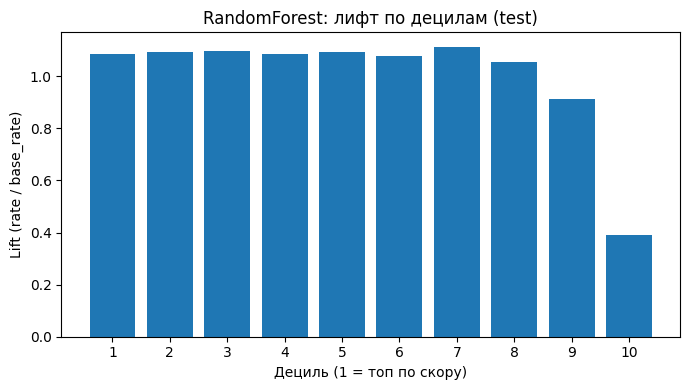

[INFO] График лифта сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/rf_lift_chart_test.png


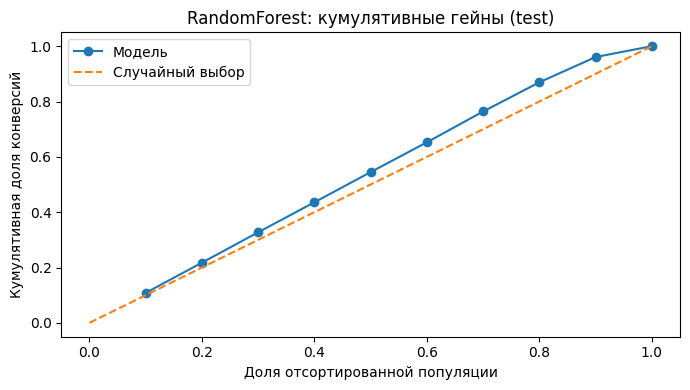

[INFO] График кумулятивных гейнов сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/rf_gains_chart_test.png
[INFO] Таблица лифта сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/rf_lift_table_test.csv


In [42]:
# ============================================================
# ЭТАП 6.2 — лифт и кумулятивные гейны на тестовой выборке
# ============================================================

def compute_lift_table(y_true: np.ndarray, y_proba: np.ndarray, n_bins: int = 10) -> pd.DataFrame:
    """Считает лифт и кумулятивные гейны по бинам (децили по умолчанию)."""
    df_tmp = pd.DataFrame({"y_true": y_true, "score": y_proba})
    df_tmp = df_tmp.sort_values("score", ascending=False).reset_index(drop=True)

    df_tmp["bin"] = pd.qcut(df_tmp.index, q=n_bins, labels=False)  # 0..n_bins-1

    total_positives = df_tmp["y_true"].sum()
    total_count = len(df_tmp)
    base_rate = total_positives / total_count

    groups = []
    cum_pos = 0
    cum_cnt = 0

    for b in range(n_bins):
        g = df_tmp[df_tmp["bin"] == b]
        cnt = len(g)
        pos = g["y_true"].sum()
        rate = pos / cnt if cnt > 0 else 0.0
        lift = rate / base_rate if base_rate > 0 else np.nan

        cum_cnt += cnt
        cum_pos += pos

        cum_rate = cum_pos / cum_cnt if cum_cnt > 0 else 0.0
        cum_gain = cum_pos / total_positives if total_positives > 0 else 0.0
        pop_share = cum_cnt / total_count

        groups.append(
            {
                "bin": b + 1,  # 1..n_bins
                "count": cnt,
                "positives": pos,
                "rate": rate,
                "lift": lift,
                "cum_count": cum_cnt,
                "cum_positives": cum_pos,
                "cum_rate": cum_rate,
                "cum_gain": cum_gain,
                "population_share": pop_share,
            }
        )

    return pd.DataFrame(groups), base_rate


lift_df, base_rate_test = compute_lift_table(y_test_np, proba_test_rf, n_bins=10)

print(f"\n[INFO] Базовая доля положительного класса на тесте: {base_rate_test:.4f}")
print("[INFO] Таблица лифта (первые строки):")
display(lift_df.head())

# --- график лифта по децилам ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(lift_df["bin"], lift_df["lift"])
ax.set_xlabel("Дециль (1 = топ по скору)")
ax.set_ylabel("Lift (rate / base_rate)")
ax.set_title("RandomForest: лифт по децилам (test)")
plt.xticks(lift_df["bin"])
plt.tight_layout()

lift_plot_path = os.path.join(PLOTS_DIR, "rf_lift_chart_test.png")
plt.savefig(lift_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График лифта сохранён в:", lift_plot_path)

# --- график кумулятивных гейнов ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(lift_df["population_share"], lift_df["cum_gain"], marker="o", label="Модель")
ax.plot([0, 1], [0, 1], linestyle="--", label="Случайный выбор")
ax.set_xlabel("Доля отсортированной популяции")
ax.set_ylabel("Кумулятивная доля конверсий")
ax.set_title("RandomForest: кумулятивные гейны (test)")
ax.legend()
plt.tight_layout()

gains_plot_path = os.path.join(PLOTS_DIR, "rf_gains_chart_test.png")
plt.savefig(gains_plot_path, dpi=150)
plt.show()
plt.close()

print("[INFO] График кумулятивных гейнов сохранён в:", gains_plot_path)

# Сохраняем таблицу лифта
lift_csv_path = os.path.join(REPORTS_DIR, "rf_lift_table_test.csv")
lift_df.to_csv(lift_csv_path, index=False, encoding="utf-8-sig")
print("[INFO] Таблица лифта сохранена в:", lift_csv_path)

In [43]:
# ============================================================
# ЭТАП 6.3 — простая модель ROI для разных порогов
# ============================================================

# Возьмём исходные признаки для тестовой выборки (чтобы получить AdSpend и др.)
df_test_features = df_fe.loc[X_test.index].copy()

def simulate_roi(
    df_subset: pd.DataFrame,
    y_true: np.ndarray,
    y_proba: np.ndarray,
    threshold: float,
    cost_col: str = "AdSpend",
    revenue_per_conversion: float = None,
) -> dict:
    """
    Простая модель ROI:
    - таргетируем всех клиентов, у кого score >= threshold;
    - стоимость контакта = значение cost_col;
    - выручка за конверсию = revenue_per_conversion (если None, берём медианное значение cost_col).
    """
    if revenue_per_conversion is None:
        revenue_per_conversion = float(df_subset[cost_col].median())

    mask_target = y_proba >= threshold
    n_target = int(mask_target.sum())
    if n_target == 0:
        return {
            "threshold": threshold,
            "n_targeted": 0,
            "n_conversions": 0,
            "total_cost": 0.0,
            "total_revenue": 0.0,
            "net_gain": 0.0,
            "roi": np.nan,
        }

    costs = df_subset.loc[mask_target, cost_col].values
    total_cost = float(costs.sum())

    n_conv = int(((y_true == 1) & mask_target).sum())
    total_revenue = n_conv * revenue_per_conversion
    net_gain = total_revenue - total_cost
    roi = net_gain / total_cost if total_cost > 0 else np.nan

    return {
        "threshold": threshold,
        "n_targeted": n_target,
        "n_conversions": n_conv,
        "total_cost": total_cost,
        "revenue_per_conversion": revenue_per_conversion,
        "total_revenue": total_revenue,
        "net_gain": net_gain,
        "roi": roi,
    }


# Посчитаем ROI для нескольких сценариев на тестовой выборке
roi_rows = []
for name, thr in threshold_scenarios.items():
    res = simulate_roi(
        df_subset=df_test_features,
        y_true=y_test_np,
        y_proba=proba_test_rf,
        threshold=thr,
        cost_col="AdSpend",
        revenue_per_conversion=None,  # возьмём медианный AdSpend как "выручку"
    )
    res["scenario"] = name
    roi_rows.append(res)

roi_df = pd.DataFrame(roi_rows)[
    [
        "scenario",
        "threshold",
        "n_targeted",
        "n_conversions",
        "total_cost",
        "revenue_per_conversion",
        "total_revenue",
        "net_gain",
        "roi",
    ]
]

print("\n[INFO] Результаты ROI-модели по сценарным порогам (test):")
display(roi_df)

roi_csv_path = os.path.join(REPORTS_DIR, "rf_roi_test_scenarios.csv")
roi_df.to_csv(roi_csv_path, index=False, encoding="utf-8-sig")
print("[INFO] Таблица ROI сохранена в:", roi_csv_path)


[INFO] Результаты ROI-модели по сценарным порогам (test):


scenario  threshold  n_targeted  n_conversions    total_cost  \
0         best_f1       0.44        1530           1390  7.753301e+06   
1     high_recall       0.48        1493           1378  7.630535e+06   
2  high_precision       0.85          86             80  5.931660e+05   
3     default_0_5       0.50        1469           1367  7.535901e+06   

   revenue_per_conversion  total_revenue       net_gain       roi  
0             4925.325854   6.846203e+06 -907097.912792 -0.116995  
1             4925.325854   6.787099e+06 -843436.197956 -0.110534  
2             4925.325854   3.940261e+05 -199139.981596 -0.335724  
3             4925.325854   6.732920e+06 -802980.472168 -0.106554

[INFO] Таблица ROI сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/rf_roi_test_scenarios.csv


## Этап 7. Сегментация клиентов и бизнес-профили

На этом этапе мы:
- рассчитываем скоринговые баллы `rf_score` для всех клиентов по чемпионской модели RandomForest;
- формируем **децильную сегментацию** по скору (1-й дециль — самые «горячие» клиенты);
- выделяем укрупнённые сегменты риска/приоритета (High / Medium / Low);
- строим **кластерную сегментацию** (KMeans) по ключевым поведенческим признакам;
- считаем агрегированные показатели по каждому сегменту/кластеру и сохраняем их в артефакты
  для дальнейшего использования во Flask-приложении.


In [44]:
# ============================================================
# ЭТАП 7.0 — скоринговый балл RandomForest для всех клиентов
# ============================================================

import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

plt.style.use("default")

# Признаковое пространство, с которым обучался RF
feature_cols_for_model = NUMERIC_FEATURES + CATEGORICAL_FEATURES

X_all = df_fe[feature_cols_for_model].copy()
y_all = df_fe[TARGET_COL].astype(int).values

# Скоринг по чемпионской модели
rf_scores_all = rf_best_pipeline.predict_proba(X_all)[:, 1]
df_fe["rf_score"] = rf_scores_all

print("[INFO] Примеры скоринговых баллов RandomForest:")
print(df_fe[["CustomerID", "rf_score", TARGET_COL]].head())

[INFO] Примеры скоринговых баллов RandomForest:
   CustomerID  rf_score  Conversion
0        8000  0.582871           1
1        8001  0.753111           1
2        8002  0.712163           1
3        8003  0.657890           1
4        8004  0.783931           1



[INFO] Сводка по децильной сегментации (1 = самые горячие):


n_clients  conversion_rate  avg_adspend  avg_engagement  \
rf_decile                                                            
1                800          0.98625  6664.652000        0.587221   
2                800          0.98500  6238.427566        0.560031   
3                800          0.98750  5715.955298        0.547759   
4                800          0.98125  5274.334731        0.531863   
5                800          0.98000  5217.722324        0.519712   
6                800          0.98000  4795.651147        0.500267   
7                800          0.96750  4459.810740        0.480471   
8                800          0.93625  4179.494826        0.459540   
9                800          0.79250  3993.726933        0.429626   
10               800          0.16875  3469.740704        0.384890   

           avg_prev_purchases  
rf_decile                      
1                     5.06875  
2                     5.07375  
3                     4.81250  
4                     4.93500  
5                     4.76500  
6                     4.61500  
7                     4.38500  
8                     4.26500  
9                     3.70875  
10                    3.22625


[INFO] Сводка по укрупнённым сегментам приоритета:


n_clients  conversion_rate  avg_adspend  avg_engagement  \
priority_segment                                                            
High                   2400         0.986250  6206.344955        0.565004   
Medium                 3200         0.977187  4936.879736        0.508078   
Low                    2400         0.632500  3880.987488        0.424686   

                  avg_prev_purchases  
priority_segment                      
High                        4.985000  
Medium                      4.675000  
Low                         3.733333

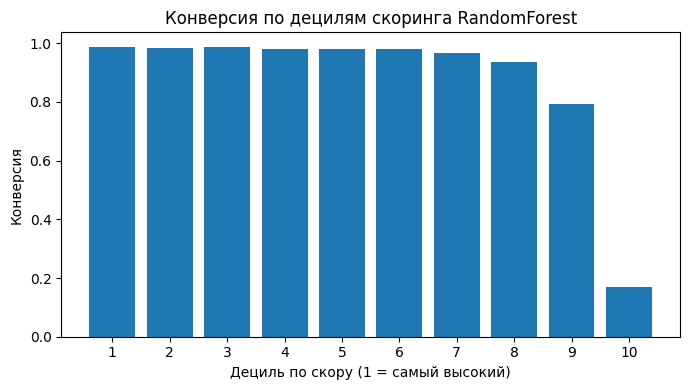

[INFO] График конверсии по децилям сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/rf_decile_conversion.png
[INFO] Децильная сегментация сохранена в: /content/drive/MyDrive/digital_marketing_conversion/data/client_segmentation_deciles.csv
[INFO] Сводка по децилям сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/rf_decile_summary.csv
[INFO] Сводка по приоритетным сегментам сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/rf_priority_segment_summary.csv


In [45]:
# ============================================================
# ЭТАП 7.1 — децильная сегментация по скору
# ============================================================

# qcut даёт бины по возрастанию; нам нужен 1-й дециль = самые высокие score.
# Сначала считаем дециль по возрастанию, затем инвертируем.
df_fe["rf_decile_asc"] = pd.qcut(df_fe["rf_score"], q=10, labels=False)
df_fe["rf_decile"] = 10 - df_fe["rf_decile_asc"]  # 1 = самый высокий скор, 10 = самый низкий
df_fe["rf_decile"] = df_fe["rf_decile"].astype(int)

# Укрупнённые сегменты приоритета
def map_priority(decile: int) -> str:
    if decile <= 3:
        return "High"    # топ-30 % по скору
    elif decile <= 7:
        return "Medium"  # середина
    else:
        return "Low"     # нижние 30 %

df_fe["priority_segment"] = df_fe["rf_decile"].apply(map_priority)

# Сводка по децилям
decile_summary = (
    df_fe
    .groupby("rf_decile")
    .agg(
        n_clients=("CustomerID", "size"),
        conversion_rate=(TARGET_COL, "mean"),
        avg_adspend=("AdSpend", "mean"),
        avg_engagement=("EngagementScore", "mean"),
        avg_prev_purchases=("PreviousPurchases", "mean"),
    )
    .sort_index()
)

print("\n[INFO] Сводка по децильной сегментации (1 = самые горячие):")
display(decile_summary)

# Сводка по укрупнённым сегментам
priority_summary = (
    df_fe
    .groupby("priority_segment")
    .agg(
        n_clients=("CustomerID", "size"),
        conversion_rate=(TARGET_COL, "mean"),
        avg_adspend=("AdSpend", "mean"),
        avg_engagement=("EngagementScore", "mean"),
        avg_prev_purchases=("PreviousPurchases", "mean"),
    )
    .sort_values("conversion_rate", ascending=False)
)

print("\n[INFO] Сводка по укрупнённым сегментам приоритета:")
display(priority_summary)

# --- графики конверсии по децилям ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(decile_summary.index, decile_summary["conversion_rate"])
ax.set_xlabel("Дециль по скору (1 = самый высокий)")
ax.set_ylabel("Конверсия")
ax.set_title("Конверсия по децилям скоринга RandomForest")
plt.xticks(decile_summary.index)
plt.tight_layout()

decile_plot_path = os.path.join(PLOTS_DIR, "rf_decile_conversion.png")
plt.savefig(decile_plot_path, dpi=150)
plt.show()
plt.close()
print("[INFO] График конверсии по децилям сохранён в:", decile_plot_path)

# --- сохранение таблиц сегментации ---
segmentation_cols = [
    ID_COL,
    TARGET_COL,
    "rf_score",
    "rf_decile",
    "priority_segment",
    "AdSpend",
    "ConversionRate",
    "WebsiteVisits",
    "PreviousPurchases",
    "LoyaltyPoints",
    "EngagementScore",
]

segmentation_path = os.path.join(DATA_DIR, "client_segmentation_deciles.csv")
df_fe[segmentation_cols].to_csv(segmentation_path, index=False, encoding="utf-8-sig")

decile_summary_path = os.path.join(REPORTS_DIR, "rf_decile_summary.csv")
priority_summary_path = os.path.join(REPORTS_DIR, "rf_priority_segment_summary.csv")

decile_summary.to_csv(decile_summary_path, encoding="utf-8-sig")
priority_summary.to_csv(priority_summary_path, encoding="utf-8-sig")

print("[INFO] Децильная сегментация сохранена в:", segmentation_path)
print("[INFO] Сводка по децилям сохранена в:", decile_summary_path)
print("[INFO] Сводка по приоритетным сегментам сохранена в:", priority_summary_path)


[INFO] Кластеризация KMeans завершена, найдено кластеров: 4
Распределение клиентов по кластерам:
cluster_kmeans
0    2163
1    1861
2    1854
3    2122
Name: count, dtype: int64

[INFO] Сводка по кластерам KMeans:


n_clients  conversion_rate  avg_score  avg_adspend  \
cluster_kmeans                                                       
2                    1854         0.943905   0.785017  4932.498256   
3                    2122         0.909519   0.740217  4808.978078   
0                    2163         0.889505   0.713552  5154.642303   
1                    1861         0.756582   0.596982  5109.413469   

                avg_engagement  avg_prev_purchases  avg_loyalty  
cluster_kmeans                                                   
2                     0.621342            4.461165  2547.592681  
3                     0.515007            4.240339  2348.505528  
0                     0.485782            4.591771  2439.926385  
1                     0.379121            4.665771  2653.420672

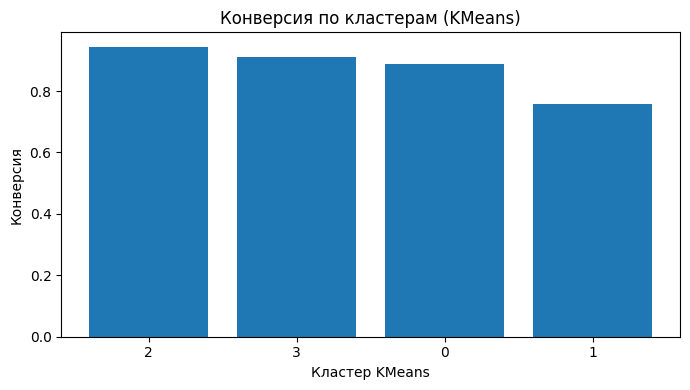

[INFO] График конверсии по кластерам сохранён в: /content/drive/MyDrive/digital_marketing_conversion/plots/kmeans_cluster_conversion.png
[INFO] Кластеры клиентов сохранены в: /content/drive/MyDrive/digital_marketing_conversion/data/client_clusters_kmeans.csv
[INFO] Сводка по кластерам сохранена в: /content/drive/MyDrive/digital_marketing_conversion/reports/kmeans_cluster_summary.csv
[INFO] Конфигурация кластеризации сохранена в: /content/drive/MyDrive/digital_marketing_conversion/data/kmeans_cluster_config.json


In [46]:
# ============================================================
# ЭТАП 7.2 — кластерная сегментация (KMeans) по поведенческим признакам
# ============================================================

# Выбираем несколько ключевых числовых признаков для кластеризации.
cluster_features = [
    "EngagementScore",
    "AdSpend",
    "ConversionRate",
    "WebsiteVisits",
    "PagesPerVisit",
    "TimeOnSite",
    "PreviousPurchases",
    "LoyaltyPoints",
]

missing_features = [f for f in cluster_features if f not in df_fe.columns]
if missing_features:
    print("[WARN] В df_fe отсутствуют признаки для кластеризации:", missing_features)

cluster_features = [f for f in cluster_features if f in df_fe.columns]

X_cluster_raw = df_fe[cluster_features].values

# Масштабируем для корректной работы KMeans
cluster_scaler = RobustScaler()
X_cluster = cluster_scaler.fit_transform(X_cluster_raw)

# Количество кластеров можно варьировать; для практики возьмём 4
N_CLUSTERS = 4

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init=20,
)

cluster_labels = kmeans.fit_predict(X_cluster)
df_fe["cluster_kmeans"] = cluster_labels

print(f"\n[INFO] Кластеризация KMeans завершена, найдено кластеров: {N_CLUSTERS}")
print("Распределение клиентов по кластерам:")
print(df_fe["cluster_kmeans"].value_counts().sort_index())

# Сводка по кластерам
cluster_summary = (
    df_fe
    .groupby("cluster_kmeans")
    .agg(
        n_clients=("CustomerID", "size"),
        conversion_rate=(TARGET_COL, "mean"),
        avg_score=("rf_score", "mean"),
        avg_adspend=("AdSpend", "mean"),
        avg_engagement=("EngagementScore", "mean"),
        avg_prev_purchases=("PreviousPurchases", "mean"),
        avg_loyalty=("LoyaltyPoints", "mean"),
    )
    .sort_values("conversion_rate", ascending=False)
)

print("\n[INFO] Сводка по кластерам KMeans:")
display(cluster_summary)

# График: конверсия по кластерам
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(cluster_summary.index.astype(str), cluster_summary["conversion_rate"])
ax.set_xlabel("Кластер KMeans")
ax.set_ylabel("Конверсия")
ax.set_title("Конверсия по кластерам (KMeans)")
plt.tight_layout()

cluster_plot_path = os.path.join(PLOTS_DIR, "kmeans_cluster_conversion.png")
plt.savefig(cluster_plot_path, dpi=150)
plt.show()
plt.close()
print("[INFO] График конверсии по кластерам сохранён в:", cluster_plot_path)

# --- Сохранение результатов кластеризации ---
clusters_path = os.path.join(DATA_DIR, "client_clusters_kmeans.csv")
df_fe[[ID_COL, "cluster_kmeans"] + cluster_features].to_csv(
    clusters_path, index=False, encoding="utf-8-sig"
)

cluster_summary_path = os.path.join(REPORTS_DIR, "kmeans_cluster_summary.csv")
cluster_summary.to_csv(cluster_summary_path, encoding="utf-8-sig")

print("[INFO] Кластеры клиентов сохранены в:", clusters_path)
print("[INFO] Сводка по кластерам сохранена в:", cluster_summary_path)

# --- Дополнительно: сохраняем конфиг кластеризации для Flask ---
cluster_config = {
    "features": cluster_features,
    "n_clusters": int(N_CLUSTERS),
}

cluster_config_path = os.path.join(DATA_DIR, "kmeans_cluster_config.json")
with open(cluster_config_path, "w", encoding="utf-8") as f:
    json.dump(cluster_config, f, indent=2, ensure_ascii=False)

print("[INFO] Конфигурация кластеризации сохранена в:", cluster_config_path)

## Этап 8. Упаковка артефактов эксперимента для Flask-приложения

На этом этапе мы:
- создаём структуру каталогов `models/` и `configs/` внутри рабочего проекта;
- сохраняем в файл:
  - чемпионскую модель RandomForest (sklearn-пайплайн с препроцессингом);
  - дополнительные модели (XGBoost, MLP), препроцессор для DL, scaler+KMeans для кластеризации;
- формируем единый `flask_serving_config.json` c путями ко всем артефактам, выбранным порогом,
  информацией о признаках, сегментах и метриках — это будет «точка входа» для Flask-приложения.


In [47]:
# ============================================================
# ЭТАП 8.0 — подготовка каталогов для моделей и конфигов
# ============================================================

import os
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

# Каталоги для сохранения артефактов
MODELS_DIR = os.path.join(BASE_DIR, "models")
CONFIGS_DIR = os.path.join(BASE_DIR, "configs")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CONFIGS_DIR, exist_ok=True)

print("[INFO] Каталоги для моделей и конфигов готовы:")
print("   MODELS_DIR :", MODELS_DIR)
print("   CONFIGS_DIR:", CONFIGS_DIR)

[INFO] Каталоги для моделей и конфигов готовы:
   MODELS_DIR : /content/drive/MyDrive/digital_marketing_conversion/models
   CONFIGS_DIR: /content/drive/MyDrive/digital_marketing_conversion/configs


In [48]:
# ============================================================
# ЭТАП 8.1 — сохранение sklearn-моделей и препроцессоров
# ============================================================

# Пути для моделей
RF_MODEL_PATH = os.path.join(MODELS_DIR, "rf_best_pipeline.joblib")
XGB_MODEL_PATH = os.path.join(MODELS_DIR, "xgb_best_pipeline.joblib")
PREPROCESS_DL_PATH = os.path.join(MODELS_DIR, "preprocess_dl.joblib")
CLUSTER_SCALER_PATH = os.path.join(MODELS_DIR, "cluster_scaler.joblib")
KMEANS_MODEL_PATH = os.path.join(MODELS_DIR, "kmeans_model.joblib")

# Чемпионская модель (RandomForest + preprocess)
joblib.dump(rf_best_pipeline, RF_MODEL_PATH)
print("[INFO] Сохранён пайплайн RandomForest:", RF_MODEL_PATH)

# XGBoost-пайплайн (для возможного сравнения в Flask)
joblib.dump(xgb_best_pipeline, XGB_MODEL_PATH)
print("[INFO] Сохранён пайплайн XGBoost:", XGB_MODEL_PATH)

# Препроцессор для DL (скалирование+one-hot до входа в MLP)
joblib.dump(preprocess_dl, PREPROCESS_DL_PATH)
print("[INFO] Сохранён preprocess_dl для MLP:", PREPROCESS_DL_PATH)

# Масштабирование и модель кластеризации
joblib.dump(cluster_scaler, CLUSTER_SCALER_PATH)
print("[INFO] Сохранён scaler для KMeans:", CLUSTER_SCALER_PATH)

joblib.dump(kmeans, KMEANS_MODEL_PATH)
print("[INFO] Сохранён KMeans-кластеризатор:", KMEANS_MODEL_PATH)

[INFO] Сохранён пайплайн RandomForest: /content/drive/MyDrive/digital_marketing_conversion/models/rf_best_pipeline.joblib
[INFO] Сохранён пайплайн XGBoost: /content/drive/MyDrive/digital_marketing_conversion/models/xgb_best_pipeline.joblib
[INFO] Сохранён preprocess_dl для MLP: /content/drive/MyDrive/digital_marketing_conversion/models/preprocess_dl.joblib
[INFO] Сохранён scaler для KMeans: /content/drive/MyDrive/digital_marketing_conversion/models/cluster_scaler.joblib
[INFO] Сохранён KMeans-кластеризатор: /content/drive/MyDrive/digital_marketing_conversion/models/kmeans_model.joblib


In [50]:
# ============================================================
# ЭТАП 8.2 — сохранение MLP-модели (Keras .keras)
# ============================================================

import tensorflow as tf

# сохраняем именно файл с расширением .keras
MLP_MODEL_PATH = os.path.join(MODELS_DIR, "mlp_conversion_model.keras")

mlp_model.save(MLP_MODEL_PATH, include_optimizer=True)
print("[INFO] MLP-модель сохранена в файле:", MLP_MODEL_PATH)

[INFO] MLP-модель сохранена в файле: /content/drive/MyDrive/digital_marketing_conversion/models/mlp_conversion_model.keras


In [51]:
# ============================================================
# ЭТАП 8.3 — единый конфиг для Flask-приложения (обновлённый)
# ============================================================

# Пути к уже сохранённым JSON/CSV-файлам из предыдущих этапов
WINSOR_CONFIG_PATH = os.path.join(DATA_DIR, "winsorization_config.json")
FEATURE_SPACE_PATH = os.path.join(DATA_DIR, "feature_space.json")
DL_FEATURE_SPACE_PATH = os.path.join(DATA_DIR, "dl_feature_space.json")
THRESHOLD_SCENARIOS_PATH = os.path.join(REPORTS_DIR, "rf_threshold_scenarios.json")
DECILE_SEGMENTATION_PATH = os.path.join(DATA_DIR, "client_segmentation_deciles.csv")
DECILE_SUMMARY_PATH = os.path.join(REPORTS_DIR, "rf_decile_summary.csv")
PRIORITY_SUMMARY_PATH = os.path.join(REPORTS_DIR, "rf_priority_segment_summary.csv")
CLUSTER_CONFIG_PATH = os.path.join(DATA_DIR, "kmeans_cluster_config.json")
CLUSTER_SUMMARY_PATH = os.path.join(REPORTS_DIR, "kmeans_cluster_summary.csv")
LIFT_TABLE_PATH = os.path.join(REPORTS_DIR, "rf_lift_table_test.csv")
ROI_TABLE_PATH = os.path.join(REPORTS_DIR, "rf_roi_test_scenarios.csv")

# Загружаем сценарные пороги (для выбора default_threshold)
with open(THRESHOLD_SCENARIOS_PATH, "r", encoding="utf-8") as f:
    threshold_scenarios = json.load(f)

default_threshold = float(threshold_scenarios.get("best_f1", 0.5))

# Краткое summary по метрикам чемпионской модели
metrics_ensembles_path = os.path.join(REPORTS_DIR, "metrics_ensembles.csv")
metrics_df = pd.read_csv(metrics_ensembles_path)

rf_test_metrics = (
    metrics_df[(metrics_df["model"] == "RandomForest") & (metrics_df["split"] == "test")]
    .iloc[0]
    .to_dict()
)

flask_serving_config = {
    "created_at": datetime.now().isoformat(),
    "project_name": "digital_marketing_conversion",
    "target_column": TARGET_COL,
    "id_column": ID_COL,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "derived_features": DERIVED_FEATURES,
    "paths": {
        "models": {
            "random_forest_pipeline": RF_MODEL_PATH,
            "xgboost_pipeline": XGB_MODEL_PATH,
            "mlp_keras_model": MLP_MODEL_PATH,   # <-- обновили
            "preprocess_dl": PREPROCESS_DL_PATH,
            "cluster_scaler": CLUSTER_SCALER_PATH,
            "kmeans_model": KMEANS_MODEL_PATH,
        },
        "configs": {
            "winsorization": WINSOR_CONFIG_PATH,
            "feature_space_tabular": FEATURE_SPACE_PATH,
            "feature_space_dl": DL_FEATURE_SPACE_PATH,
            "threshold_scenarios": THRESHOLD_SCENARIOS_PATH,
            "kmeans_cluster": CLUSTER_CONFIG_PATH,
        },
        "reports": {
            "metrics_ensembles": metrics_ensembles_path,
            "rf_decile_summary": DECILE_SUMMARY_PATH,
            "rf_priority_summary": PRIORITY_SUMMARY_PATH,
            "kmeans_cluster_summary": CLUSTER_SUMMARY_PATH,
            "lift_table_test": LIFT_TABLE_PATH,
            "roi_scenarios_test": ROI_TABLE_PATH,
        },
        "data": {
            "client_segmentation_deciles": DECILE_SEGMENTATION_PATH,
            "client_clusters_kmeans": os.path.join(DATA_DIR, "client_clusters_kmeans.csv"),
        },
    },
    "serving": {
        "champion_model": "random_forest_pipeline",
        "default_threshold": default_threshold,
        "threshold_scenarios": threshold_scenarios,
        "priority_segment_column": "priority_segment",
        "priority_levels_order": ["High", "Medium", "Low"],
    },
    "champion_test_metrics": rf_test_metrics,
}

FLASK_CONFIG_PATH = os.path.join(CONFIGS_DIR, "flask_serving_config.json")
with open(FLASK_CONFIG_PATH, "w", encoding="utf-8") as f:
    json.dump(flask_serving_config, f, indent=2, ensure_ascii=False)

print("\n[INFO] Единый конфиг для Flask-приложения сохранён в:", FLASK_CONFIG_PATH)

# Короткий README о том, что где лежит
readme_lines = [
    "Артефакты эксперимента для Flask-приложения",
    "=========================================",
    "",
    f"Дата создания: {flask_serving_config['created_at']}",
    "",
    "Основное:",
    f"- Чемпионская модель: RandomForest (путь: {RF_MODEL_PATH})",
    f"- Default-порог классификации: {default_threshold:.3f}",
    f"- Конфиг сервинга: {FLASK_CONFIG_PATH}",
    "",
    "Дополнительно см. flask_serving_config.json для всех путей и настроек.",
]

README_PATH = os.path.join(BASE_DIR, "README_artifacts.txt")
with open(README_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(readme_lines))

print("[INFO] README по артефактам сохранён в:", README_PATH)


[INFO] Единый конфиг для Flask-приложения сохранён в: /content/drive/MyDrive/digital_marketing_conversion/configs/flask_serving_config.json
[INFO] README по артефактам сохранён в: /content/drive/MyDrive/digital_marketing_conversion/README_artifacts.txt


In [52]:
# ============================================================
# ЭТАП 8.4 — архив всех артефактов и скачивание в Colab
# ============================================================

import shutil
from google.colab import files

# Создаём zip-архив всей папки проекта BASE_DIR
ARCHIVE_BASE = os.path.join(BASE_DIR, "digital_marketing_artifacts")
ARCHIVE_PATH = shutil.make_archive(
    base_name=ARCHIVE_BASE,
    format="zip",
    root_dir=BASE_DIR,
)

print("[INFO] Архив с артефактами создан:", ARCHIVE_PATH)

# В Colab появится кнопка скачивания
files.download(ARCHIVE_PATH)

[INFO] Архив с артефактами создан: /content/drive/MyDrive/digital_marketing_conversion/digital_marketing_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>